In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

import sys;
# path to t5-experiments repo
sys.path.append('..')

In [3]:
from data_utils import T5PretrainingDataset, text_preprocessor

In [2]:
from utils import get_cls_by_name
import json
from pathlib import Path
import torch
from transformers import T5Config, T5Tokenizer

def load_experiment(path, t5_configs_path, checkpoint=None, check_commit=True):
    path = Path(path)
    cfg = json.load((path / 'config.json').open('r'))
    model_cfg = Path(t5_configs_path) / cfg['model_cfg'] if cfg['model_cfg'] is not None else None
    model_cls = get_cls_by_name(cfg['model_cls'])
    if check_commit:
        assert cfg['COMMIT'] == get_git_hash_commit(), f"expected commit {cfg['COMMIT']}, " \
                                                       f"but current is {get_git_hash_commit()}"
    # take latest checkpoint
    if checkpoint is None:
        checkpoint = list(sorted(path.glob('*.pth'), key=lambda x: x.stat().st_ctime))[-1]

    if model_cfg is None:
        t5config = T5Config.from_pretrained(cfg['base_model'])
    else:
        t5config = T5Config.from_json_file(model_cfg)

    t5tokenizer = T5Tokenizer.from_pretrained(cfg['base_model'])

    model = model_cls(config=t5config)

    state_dict = torch.load(str(checkpoint), map_location='cpu')
    model.load_state_dict(state_dict["model_state_dict"])
    print(f'Model was loaded from: {checkpoint}')
    model.eval()
    return model, t5tokenizer


import subprocess
def get_git_hash_commit() -> str:
    return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()

In [4]:
# from utils import load_experiment, get_git_hash_commit

In [4]:
from pathlib import Path

data_path = Path('../data/toy_pretraining_data/').expanduser().absolute()
shards = list(sorted([str(sh) for sh in data_path.glob('*.txt')]))
t5dataset = T5PretrainingDataset(shards, batch_size=1, text_preprocessor=text_preprocessor,
                                     inputs_len=32, targets_len=32)

/cephfs/home/kuratov/text-to-text-transfer-transformer/t5/seqio/preprocessors.py:64: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return dataset.map(


In [1]:
# load_experiment(path, t5_configs_path, checkpoint=None, check_commit=True)
# path - path to folder with pre-trained models
# checkpoint - `model_1000`, by default is None and loads the latest checkpoint
# check_commit - ensures that model was loaded from the same state of repository (with the same code as was trained)

In [31]:
model, tokenizer = load_experiment('../runs/small_wiki_bs_128_enc_mem_20/', t5_configs_path='/home/kuratov/t5-experiments', check_commit=False)

Model was loaded from: ../runs/small_wiki_bs_128_enc_mem_20/model_900000.pth


In [32]:
num_memory_tokens = 0
if hasattr(model.encoder, 'memory_tokens'):
    num_memory_tokens = model.encoder.memory_tokens.shape[0]
num_memory_tokens

20

In [6]:
x = next(iter(t5dataset))

In [7]:
x.keys()

dict_keys(['inputs', 'targets', 'inputs_mask', 'targets_mask'])

In [33]:
x['targets'][x['targets'] == -100] = 0
outputs = model(input_ids=x['inputs'], attention_mask=x['inputs_mask'], decoder_input_ids=x['targets'], decoder_attention_mask=x['targets_mask'],
               return_dict=True, output_attentions=True)

In [34]:
outputs.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

In [35]:
# 12
outputs['decoder_attentions'][0].shape

torch.Size([1, 8, 32, 32])

In [36]:
# 12
outputs['cross_attentions'][0].shape

torch.Size([1, 8, 32, 52])

In [37]:
# 12
# cdQ_attention
if isinstance(outputs['encoder_attentions'][0], tuple):
    if outputs['encoder_attentions'][0][0] is not None:
        # model has cdq and regular attention heads
        print('attentions:', outputs['encoder_attentions'][0][0].shape)
    print('cdQ attentions:', outputs['encoder_attentions'][0][1].shape)
    print('P_attentions:', outputs['encoder_attentions'][0][2].shape)

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False):
    # attentions n_layers x n_heads x len x len
    fig = plt.figure(figsize=(30, 30))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(30, 90))

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [39]:
def get_actual_seq_len(tokens):
    if '<pad>' in tokens:
        return tokens.index('<pad>')
    return len(tokens)

tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in x['inputs'][0].tolist()]
y_tokens = [tokenizer.convert_ids_to_tokens(t_id).replace('▁', '') for t_id in x['targets'][0].tolist()]

tokens = tokens[:get_actual_seq_len(tokens)]
tokens = ['[MEM]'] * num_memory_tokens + tokens
y_tokens = y_tokens[:get_actual_seq_len(y_tokens)]

layer: 0
att_heads:


<ipython-input-38-68cfccfdbd53>:35: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(y_tokens, fontdict)


<Figure size 2160x2160 with 0 Axes>

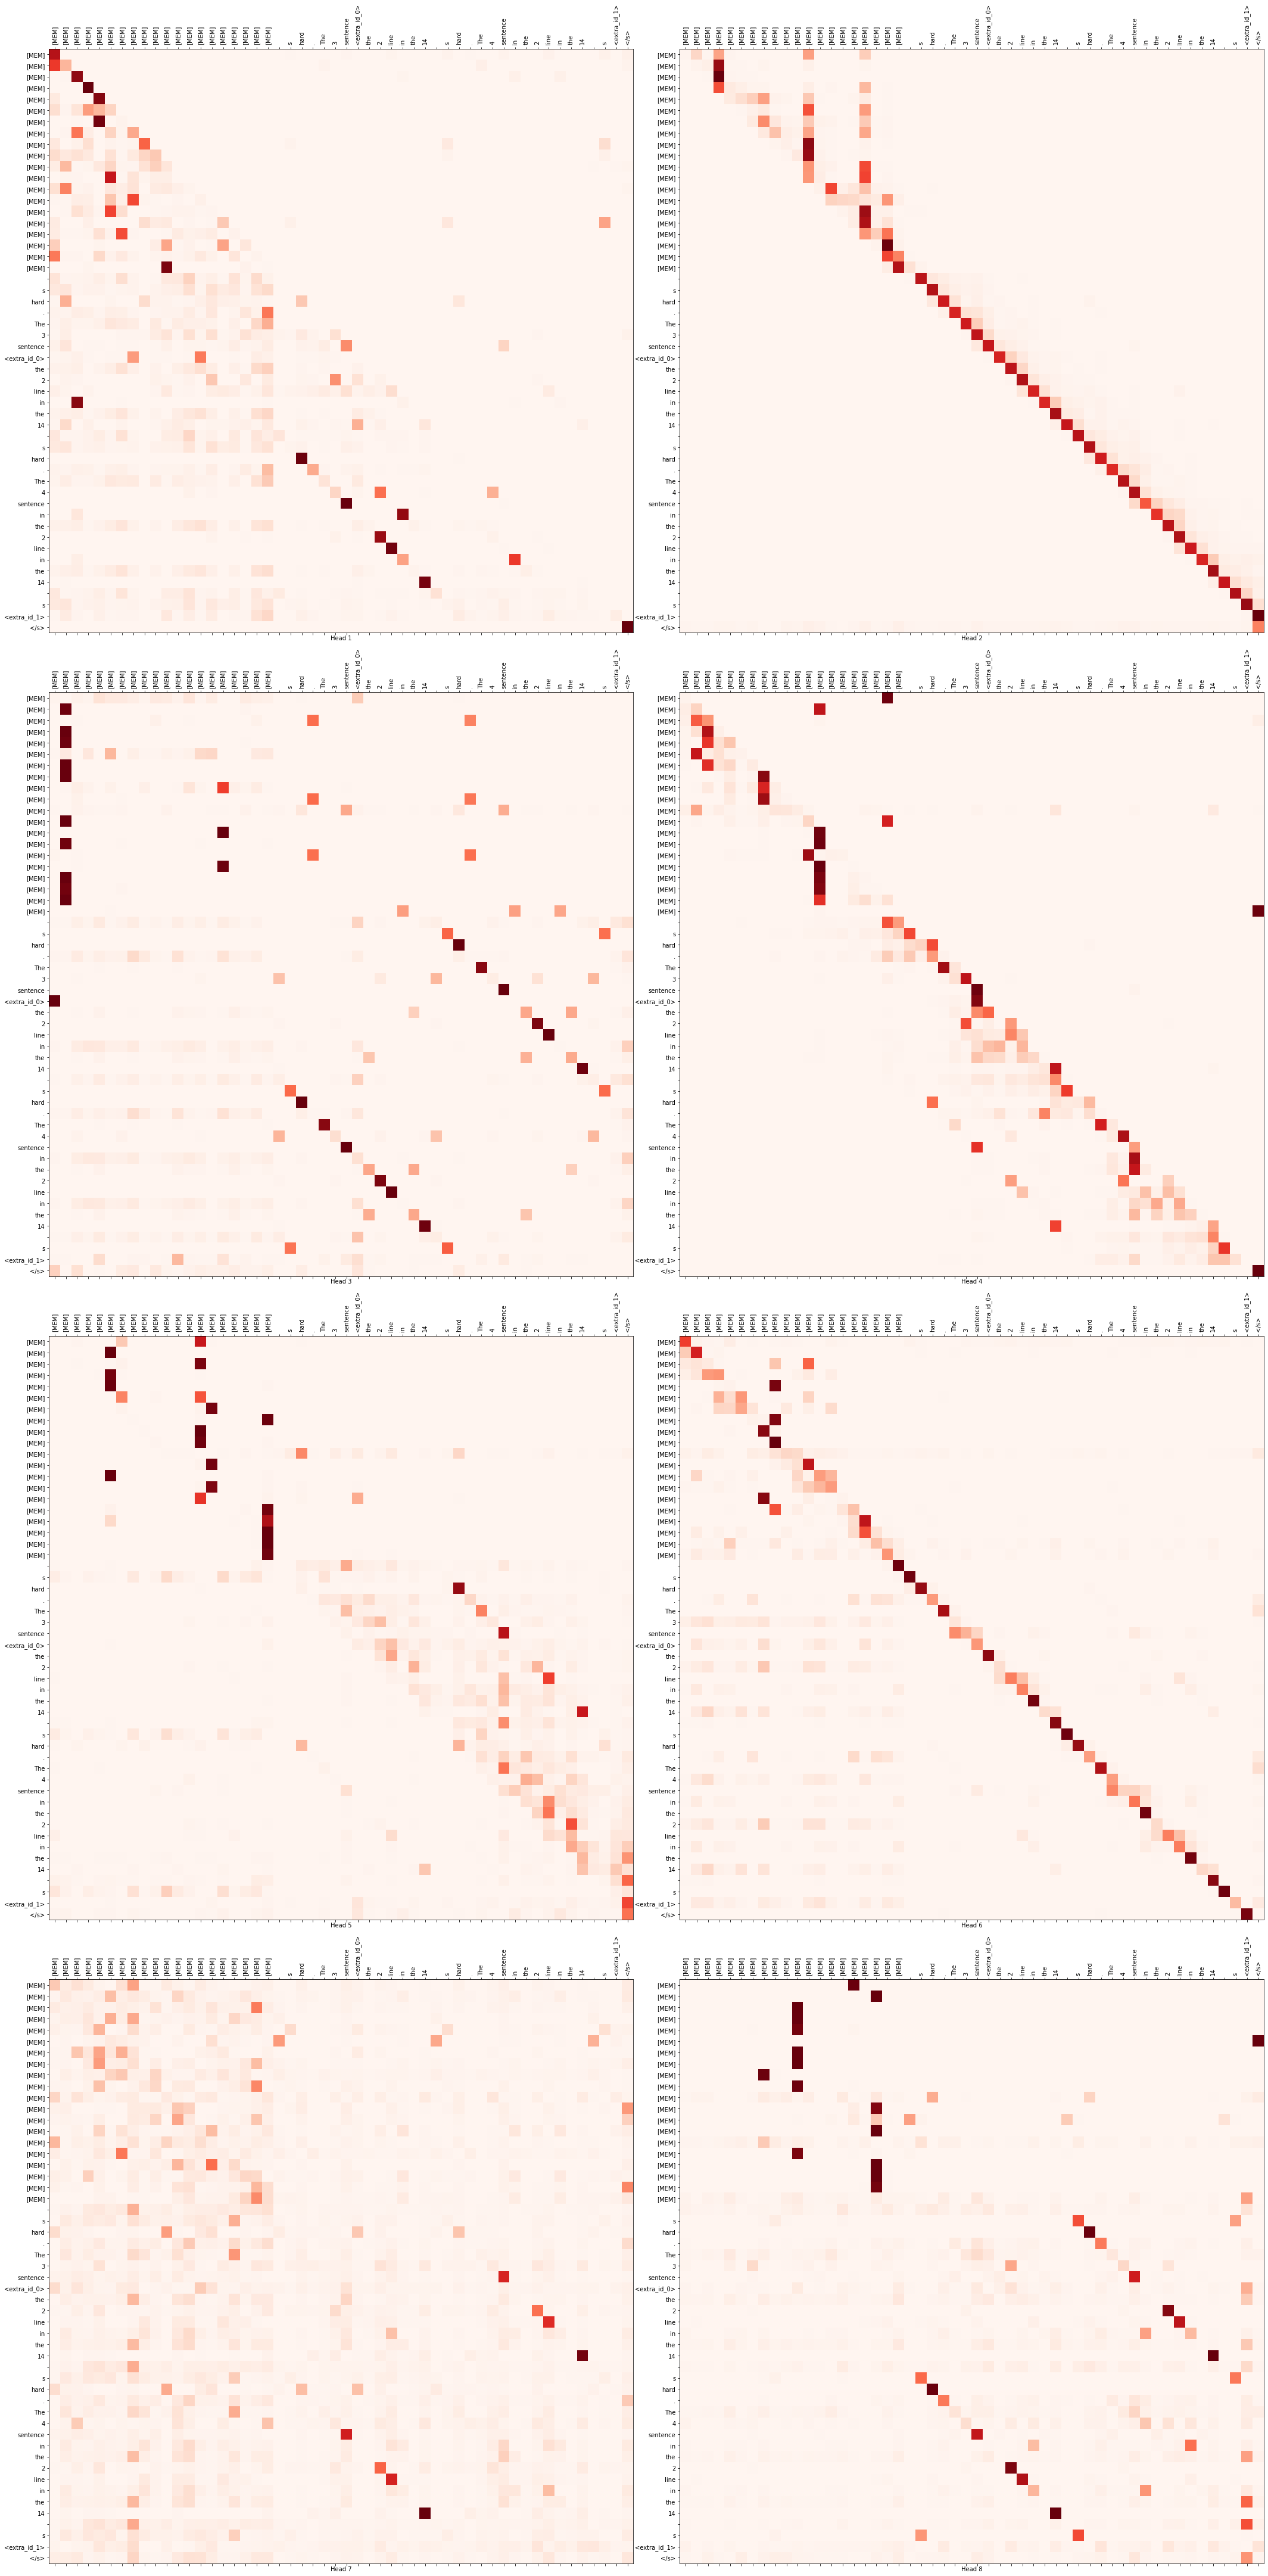

layer: 1
att_heads:


<Figure size 2160x2160 with 0 Axes>

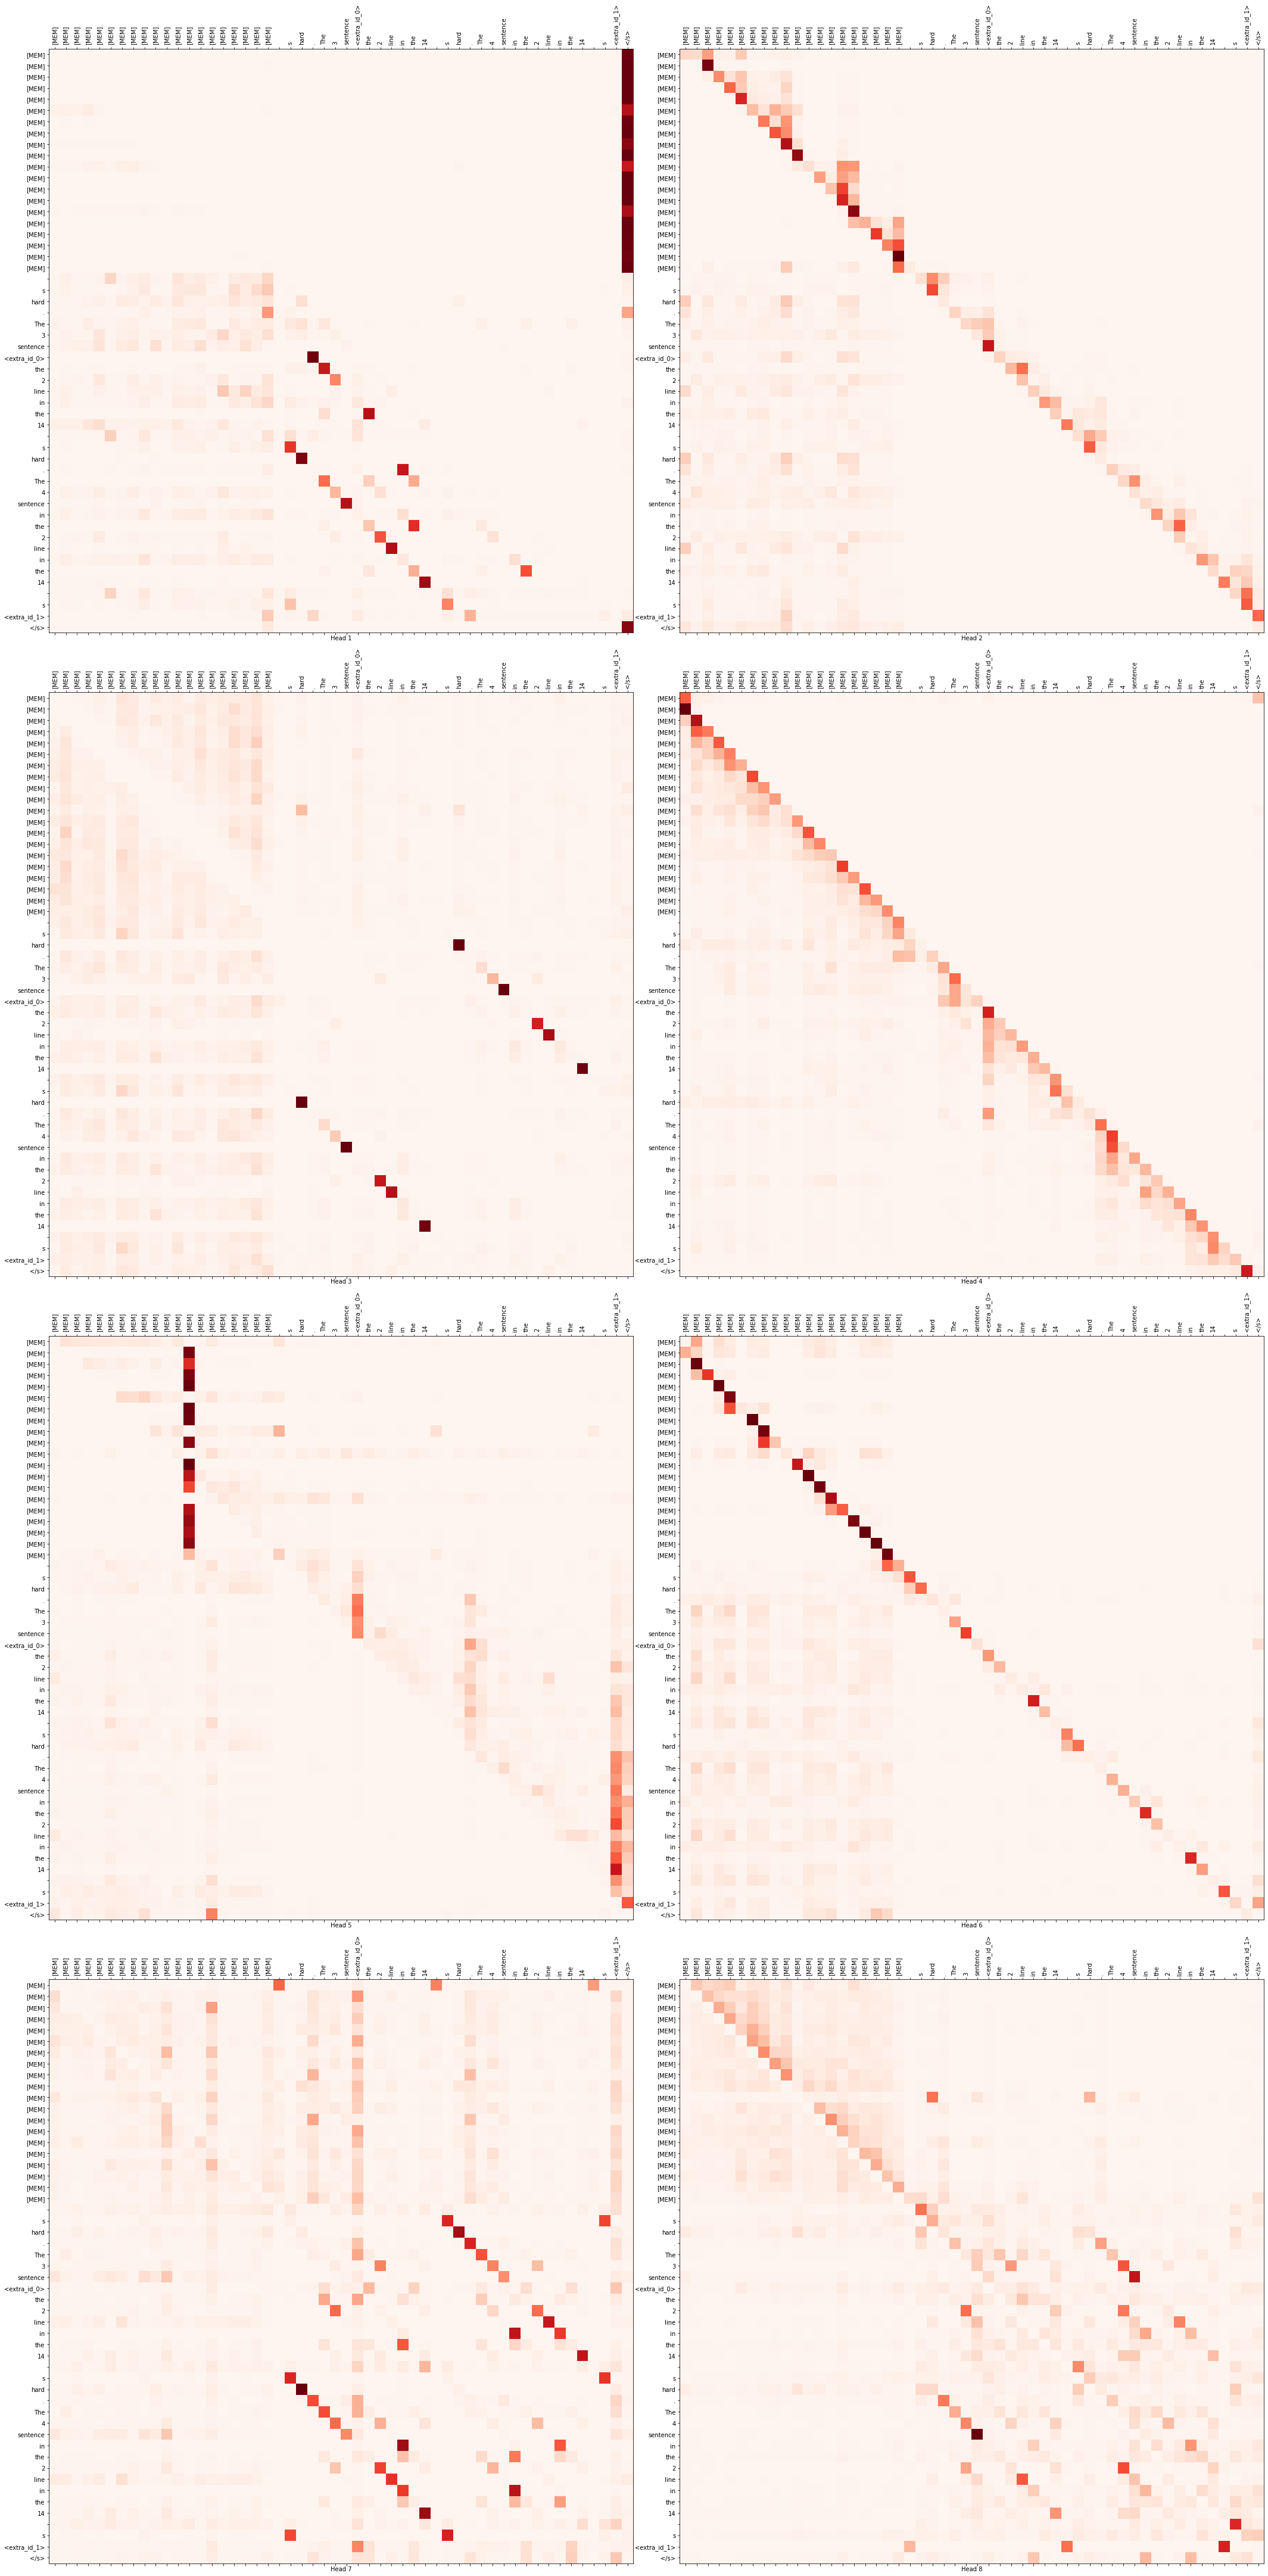

layer: 2
att_heads:


<Figure size 2160x2160 with 0 Axes>

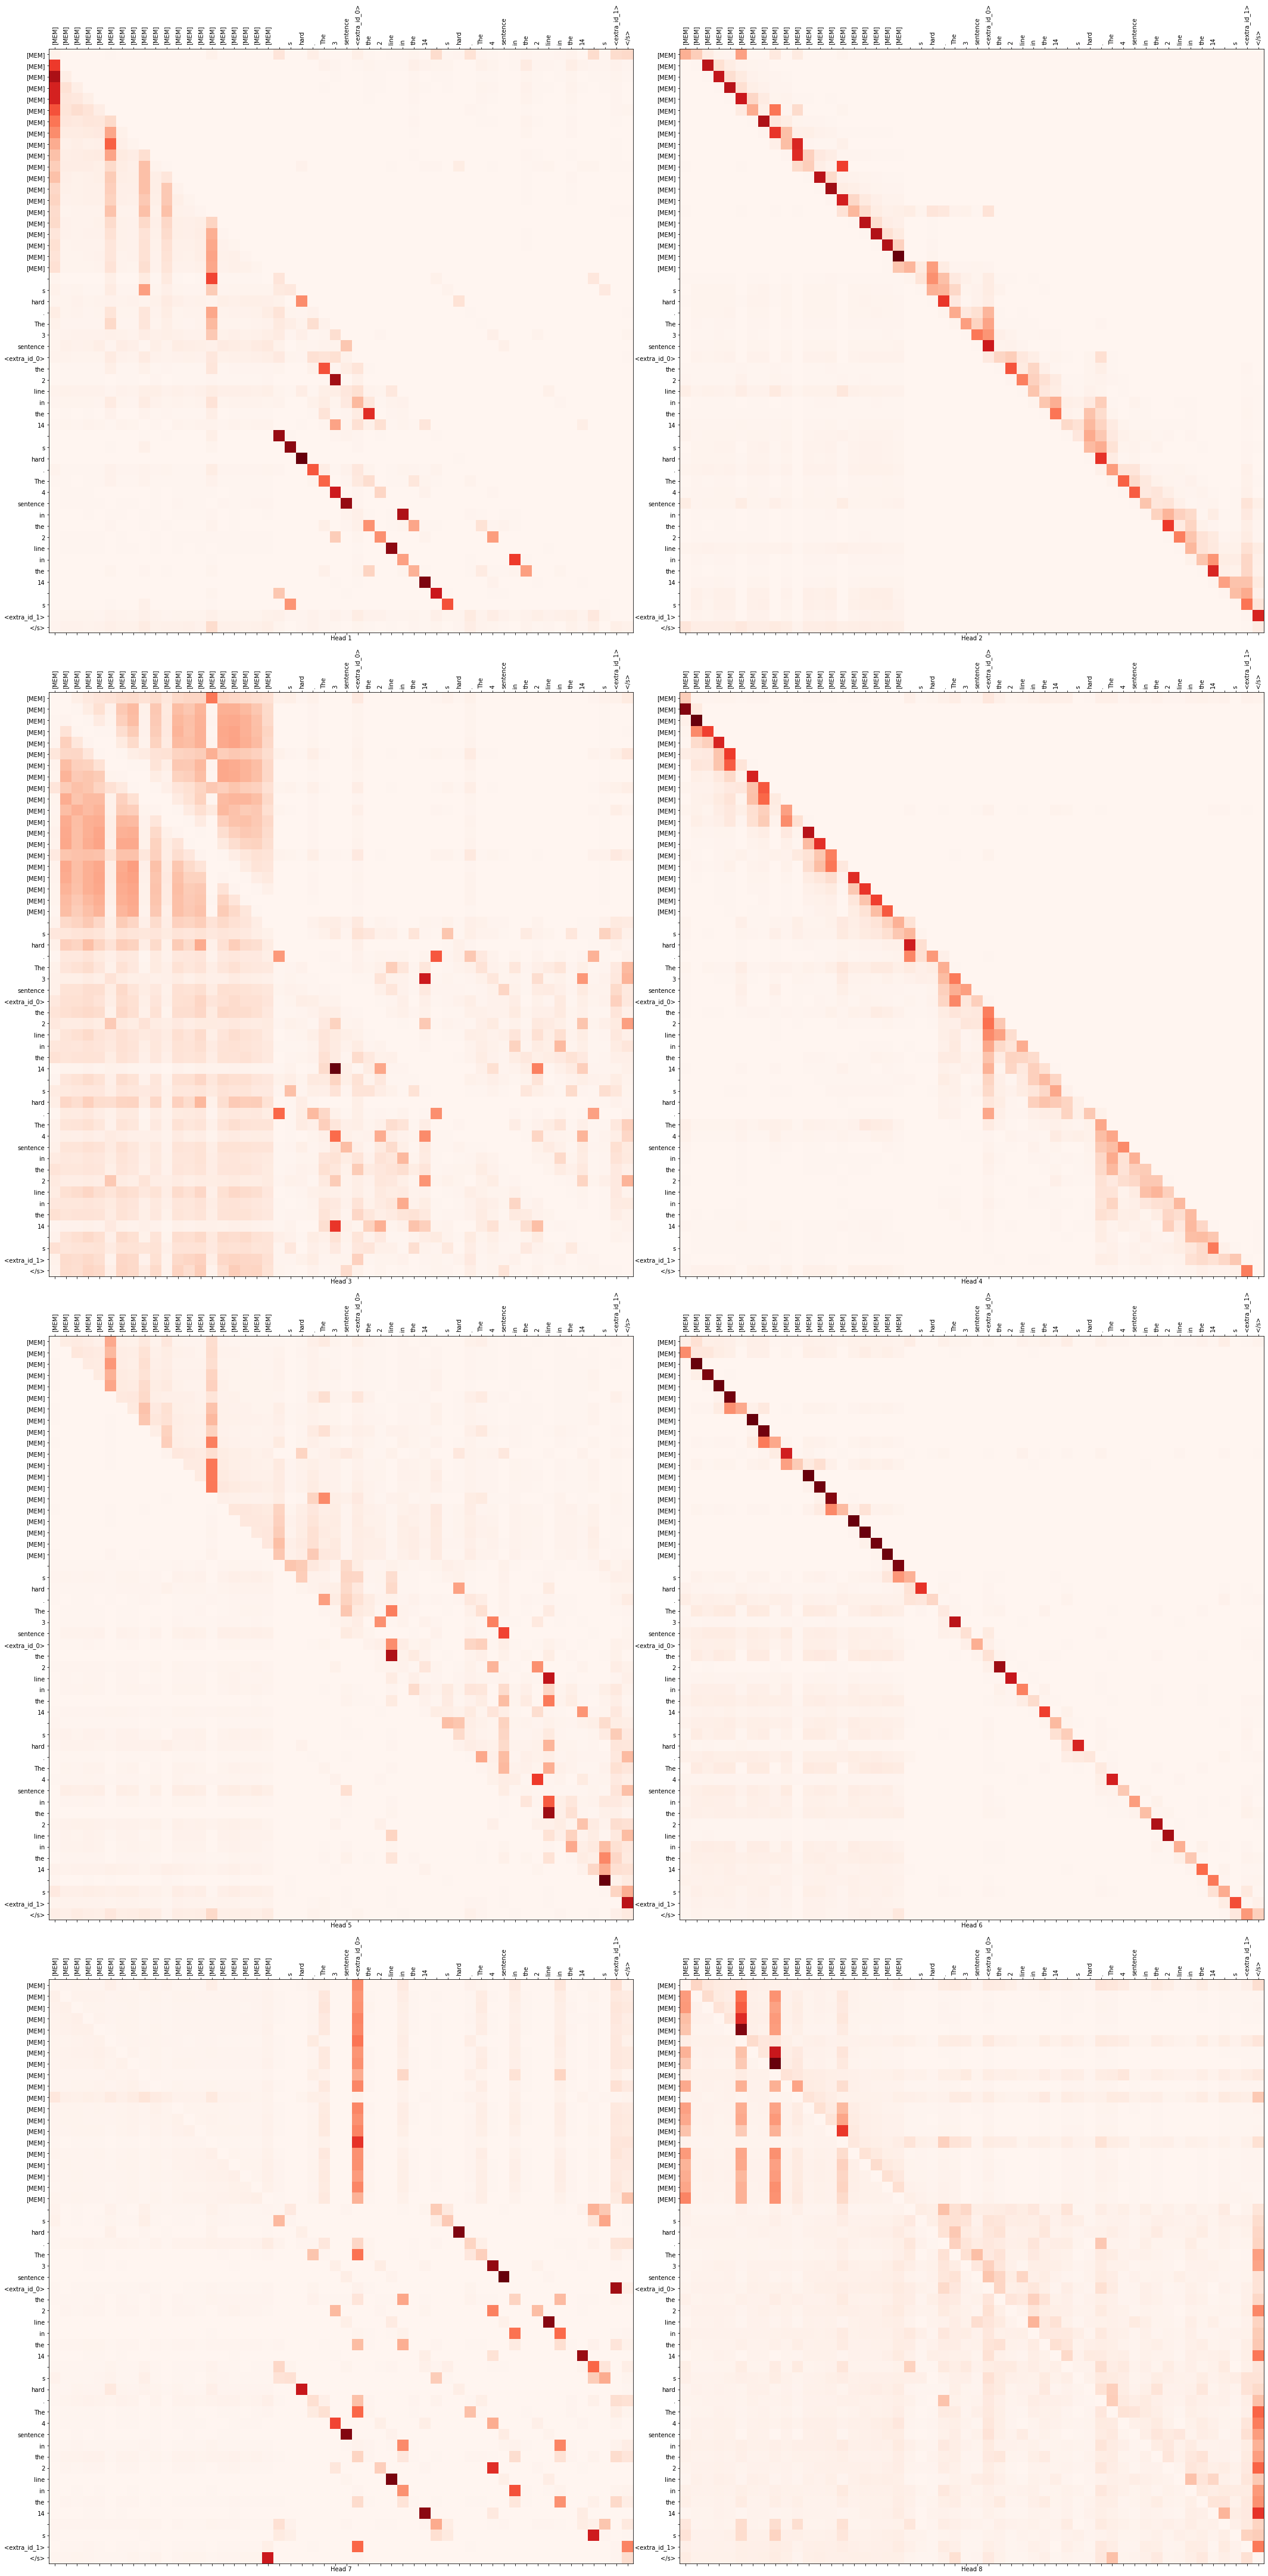

layer: 3
att_heads:


<Figure size 2160x2160 with 0 Axes>

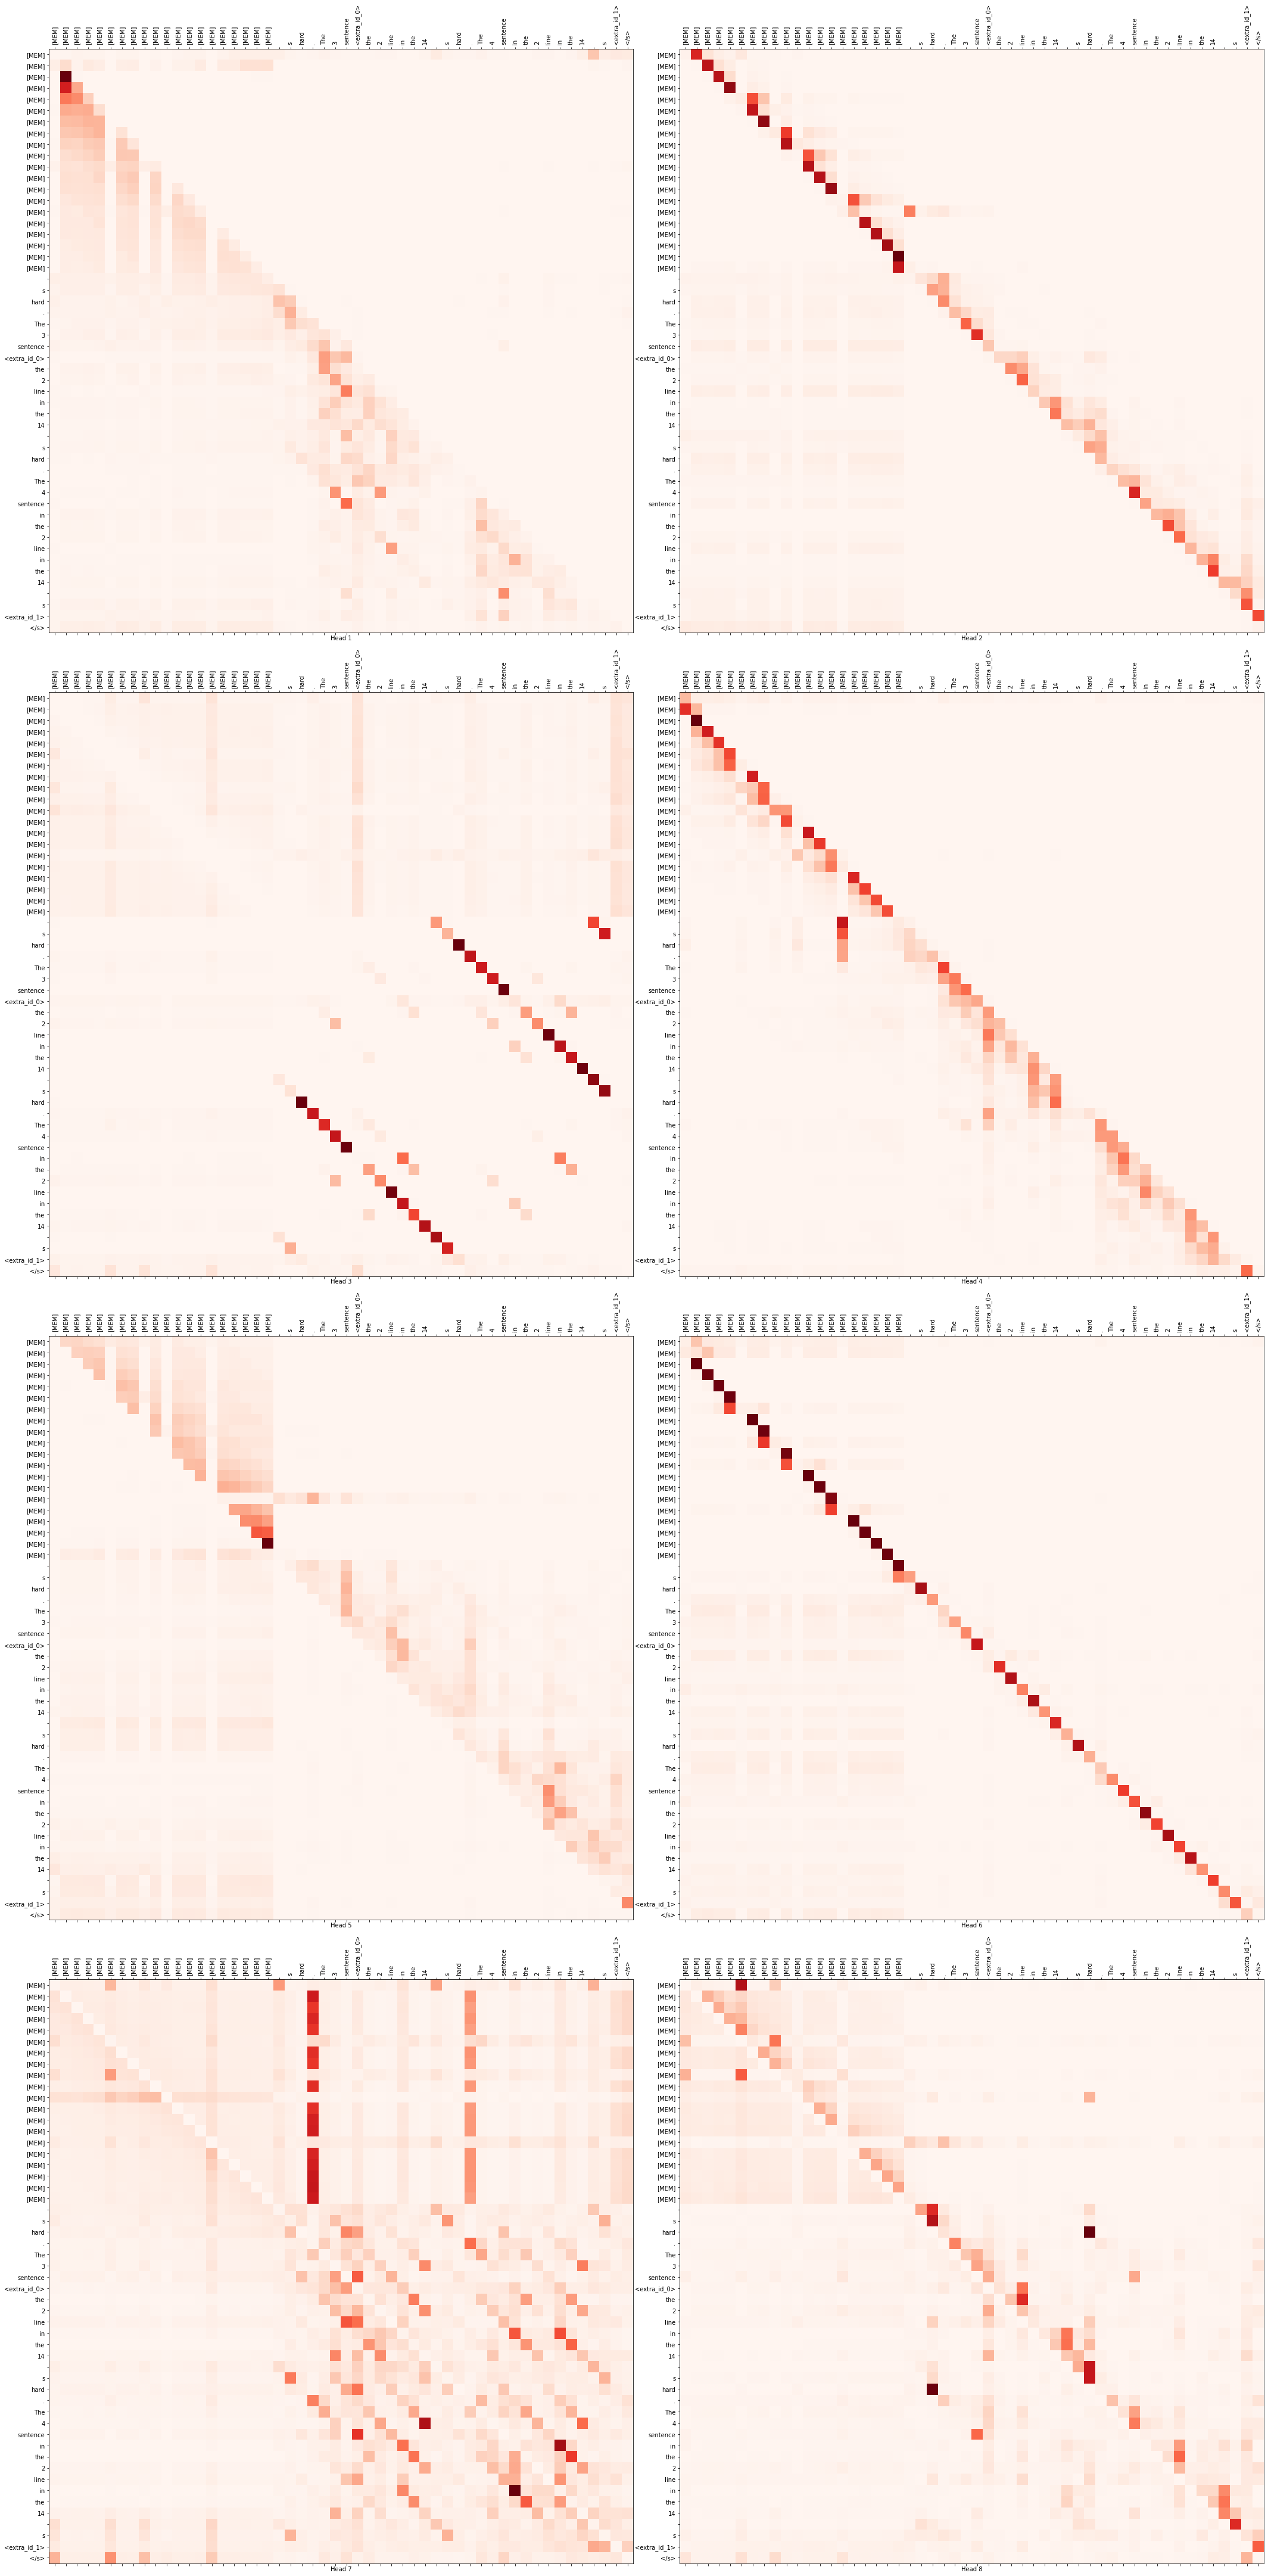

layer: 4
att_heads:


<Figure size 2160x2160 with 0 Axes>

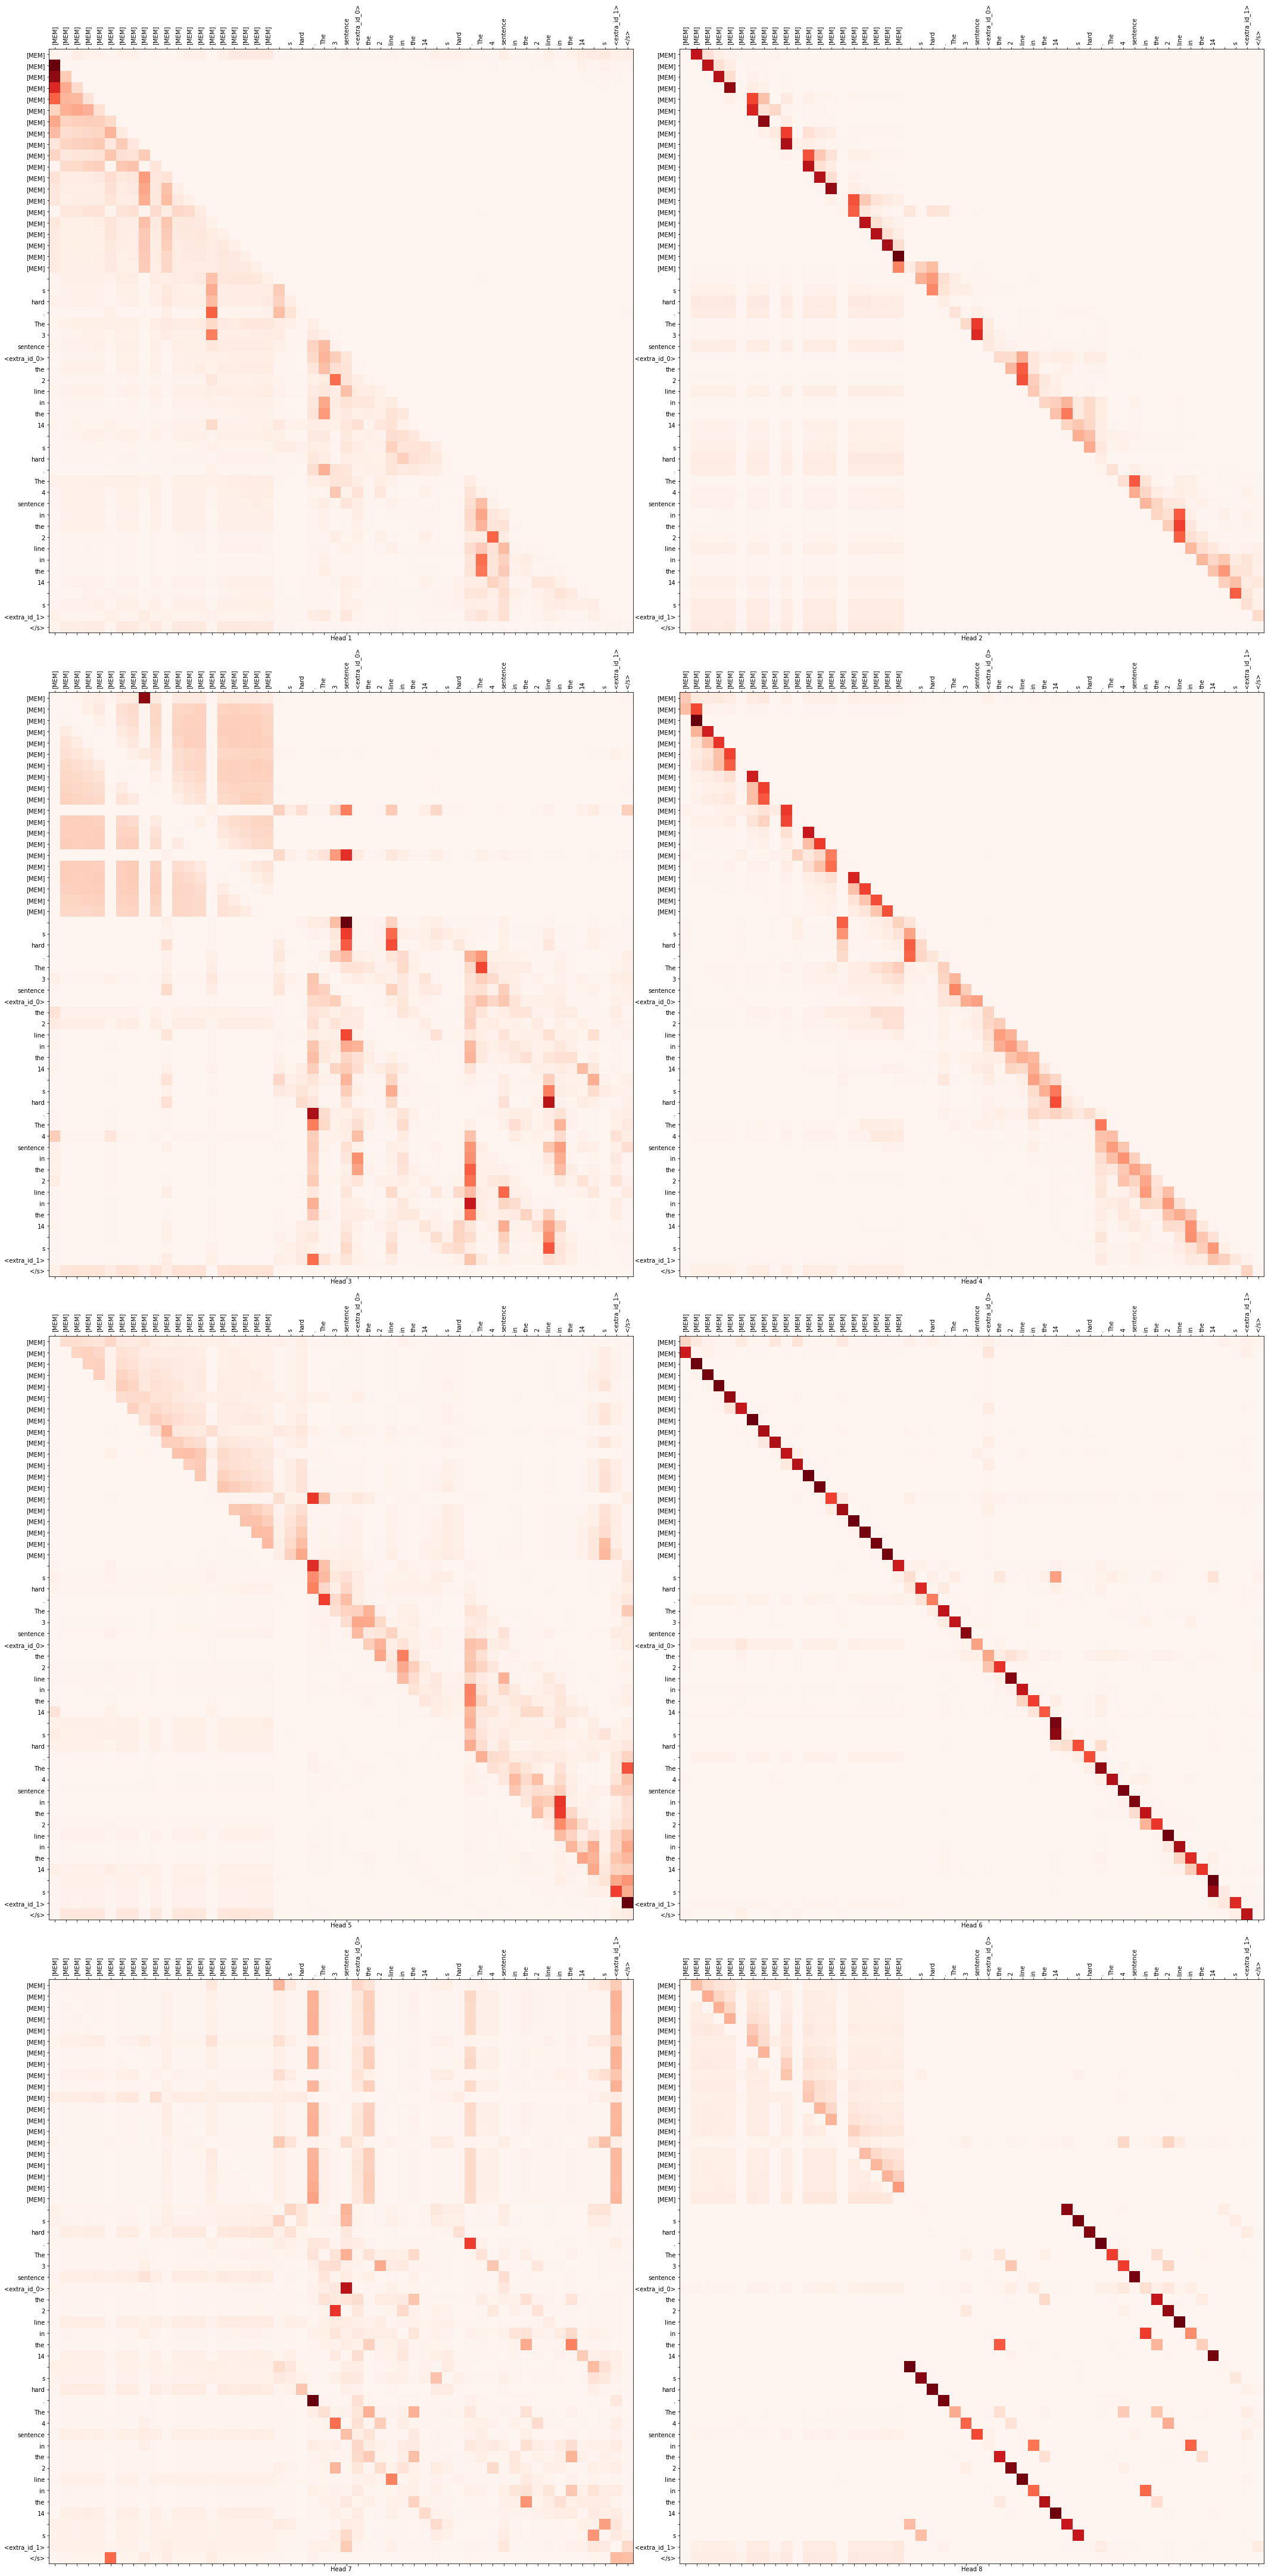

layer: 5
att_heads:


<Figure size 2160x2160 with 0 Axes>

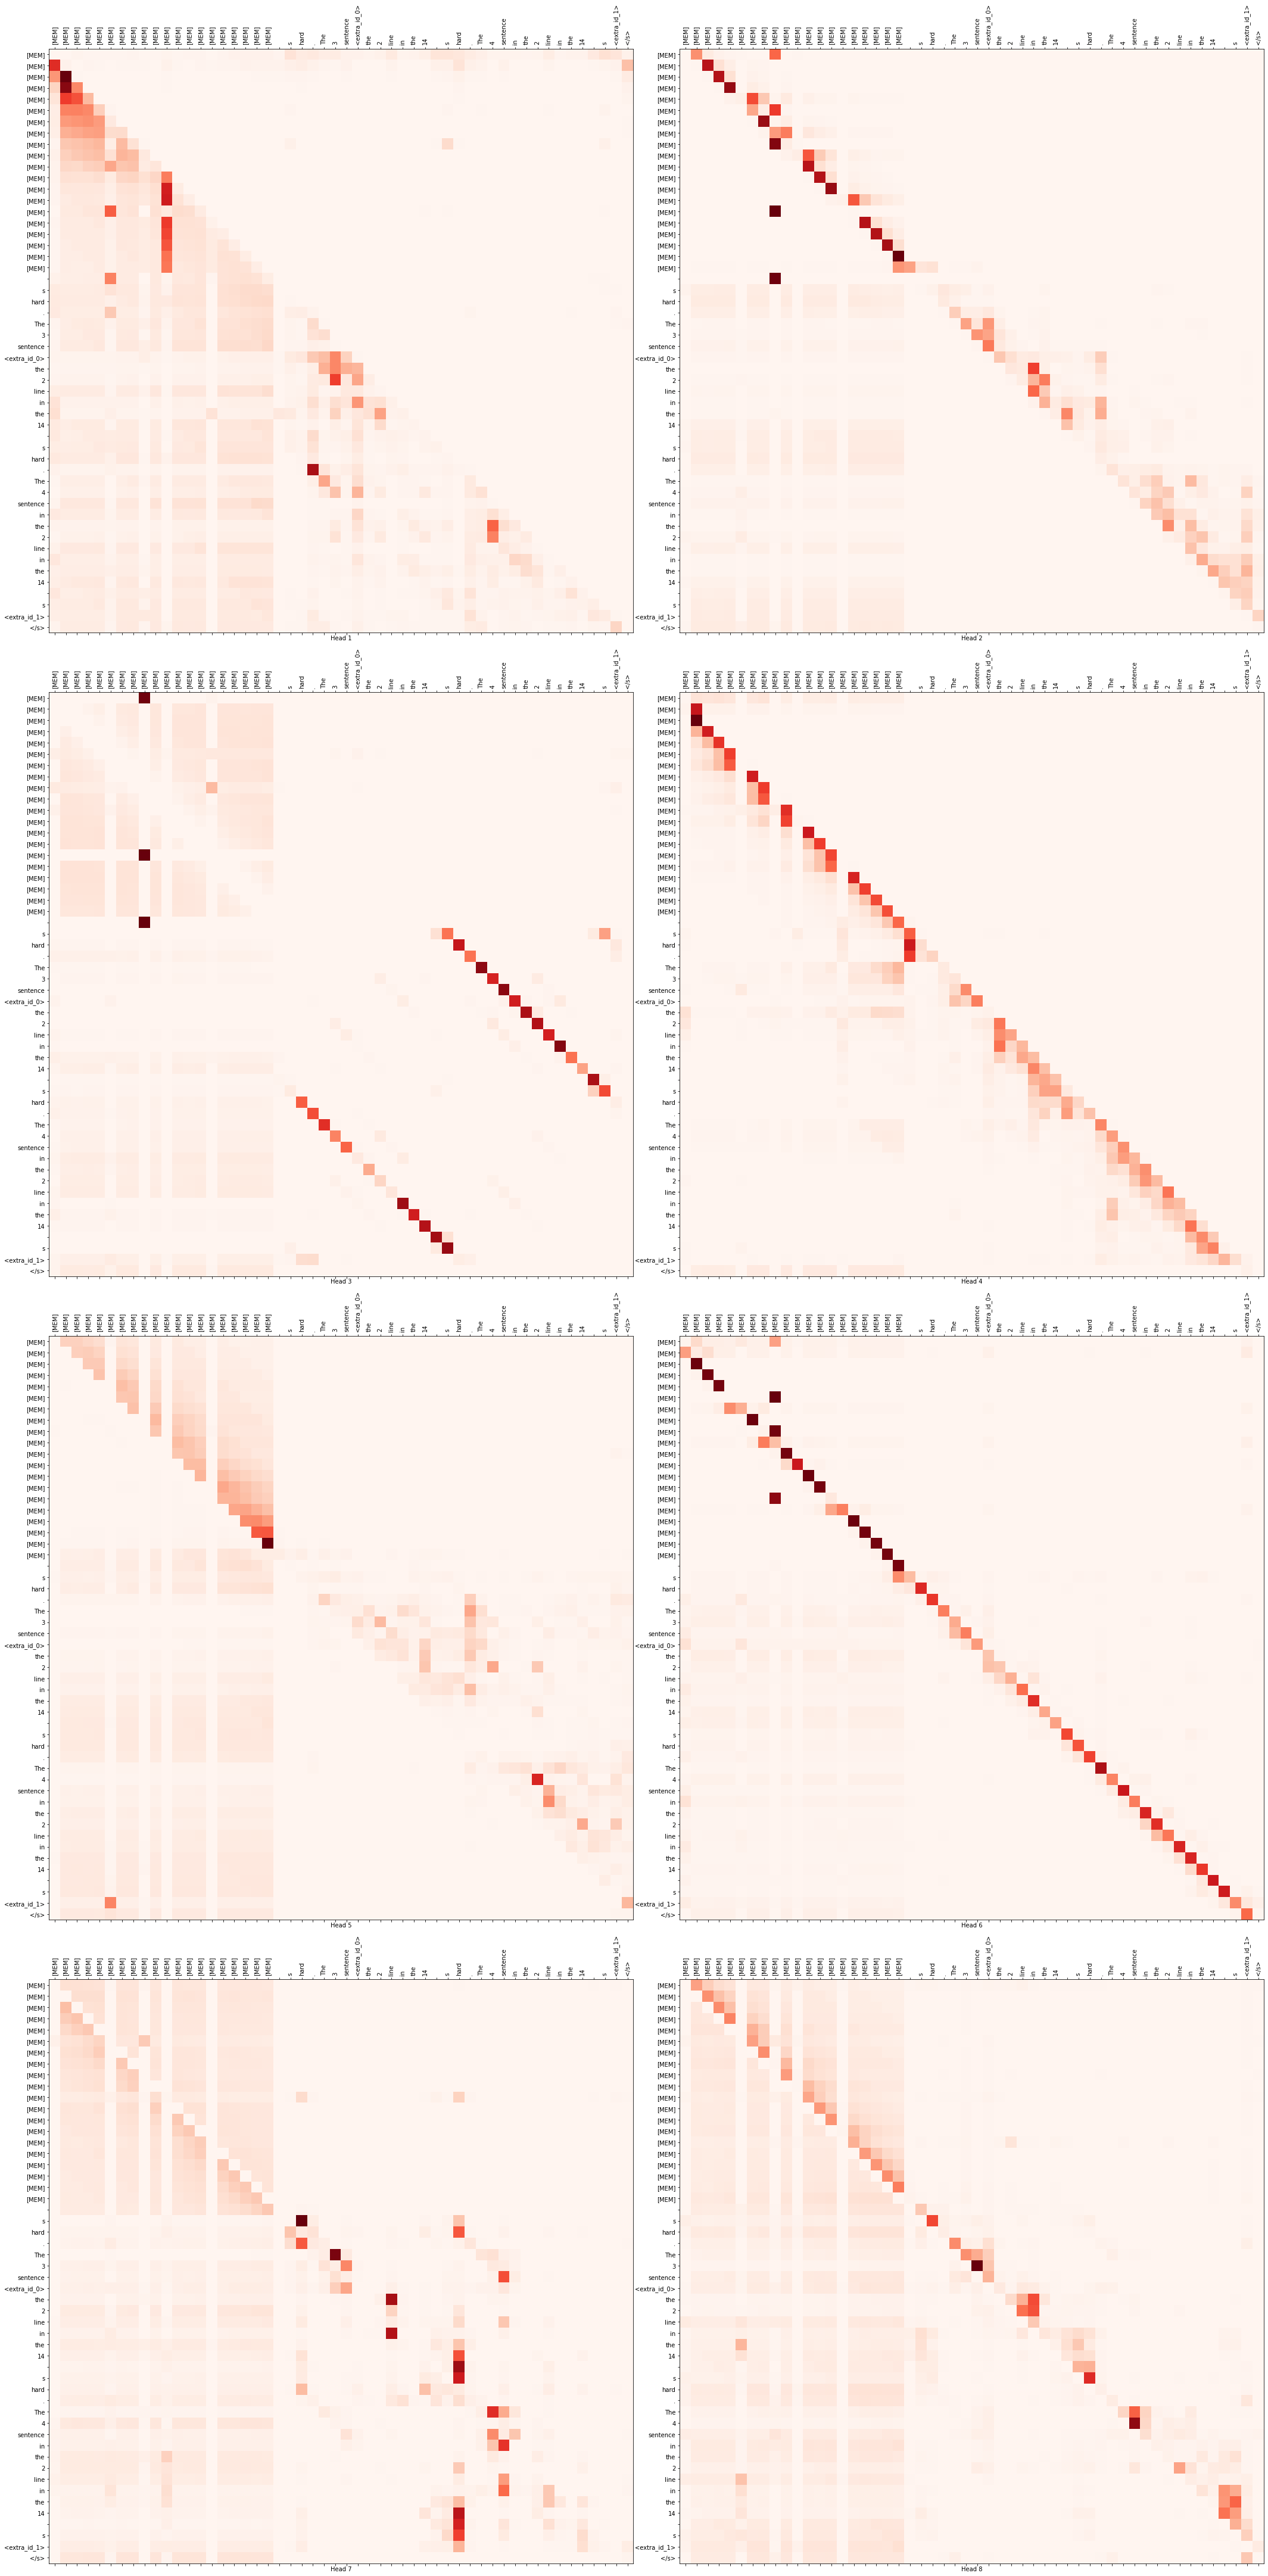

In [40]:
for layer in range(len(outputs['encoder_attentions'])):
    print(f'layer: {layer}')
    if isinstance(outputs['encoder_attentions'][0], tuple):
        attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in outputs['encoder_attentions']]
        cd_attentions = [layer_atts[1].detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
        p_attentions = [layer_atts[2].detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
    else:
        p_attentions = None
        attentions = [layer_atts.detach().squeeze().numpy() for layer_atts in outputs['encoder_attentions']]
    if attentions[0] is not None:
        # has regular attention heads
        print(f'att_heads:')
        plot_attention_weights(attentions, tokens=tokens, layer=layer, y_tokens=None, p_attentions=None)
    if p_attentions:
        print(f'cdq att heads:')
        plot_attention_weights(cd_attentions, tokens=tokens, layer=layer, y_tokens=None, p_attentions=p_attentions)

cross-attention
layer: 0
att_heads:


<ipython-input-38-68cfccfdbd53>:35: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(y_tokens, fontdict)


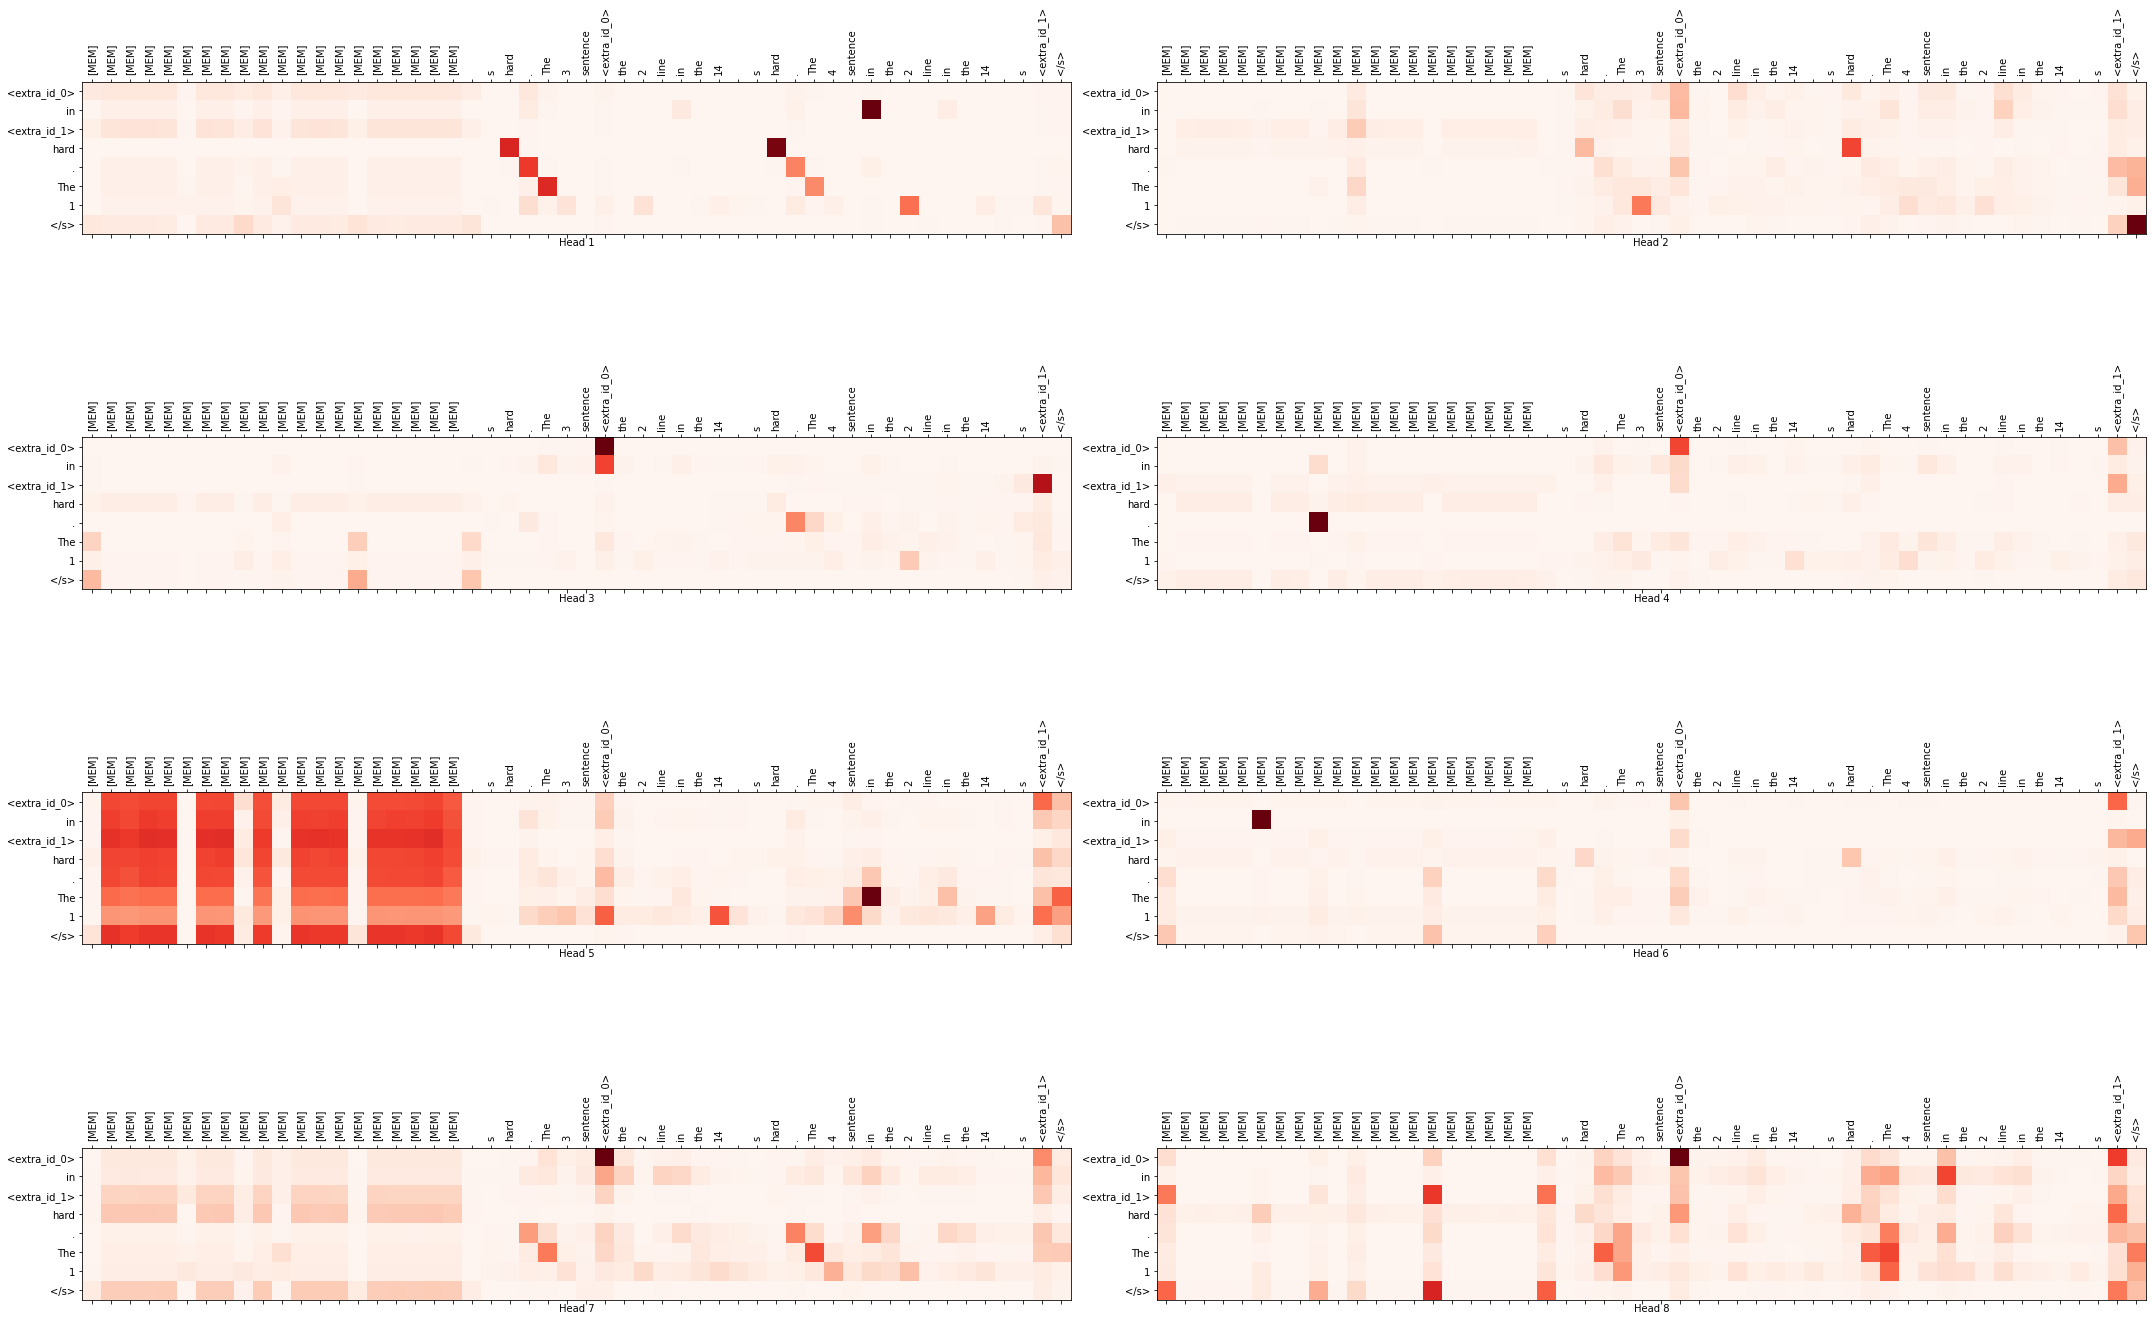

layer: 1
att_heads:


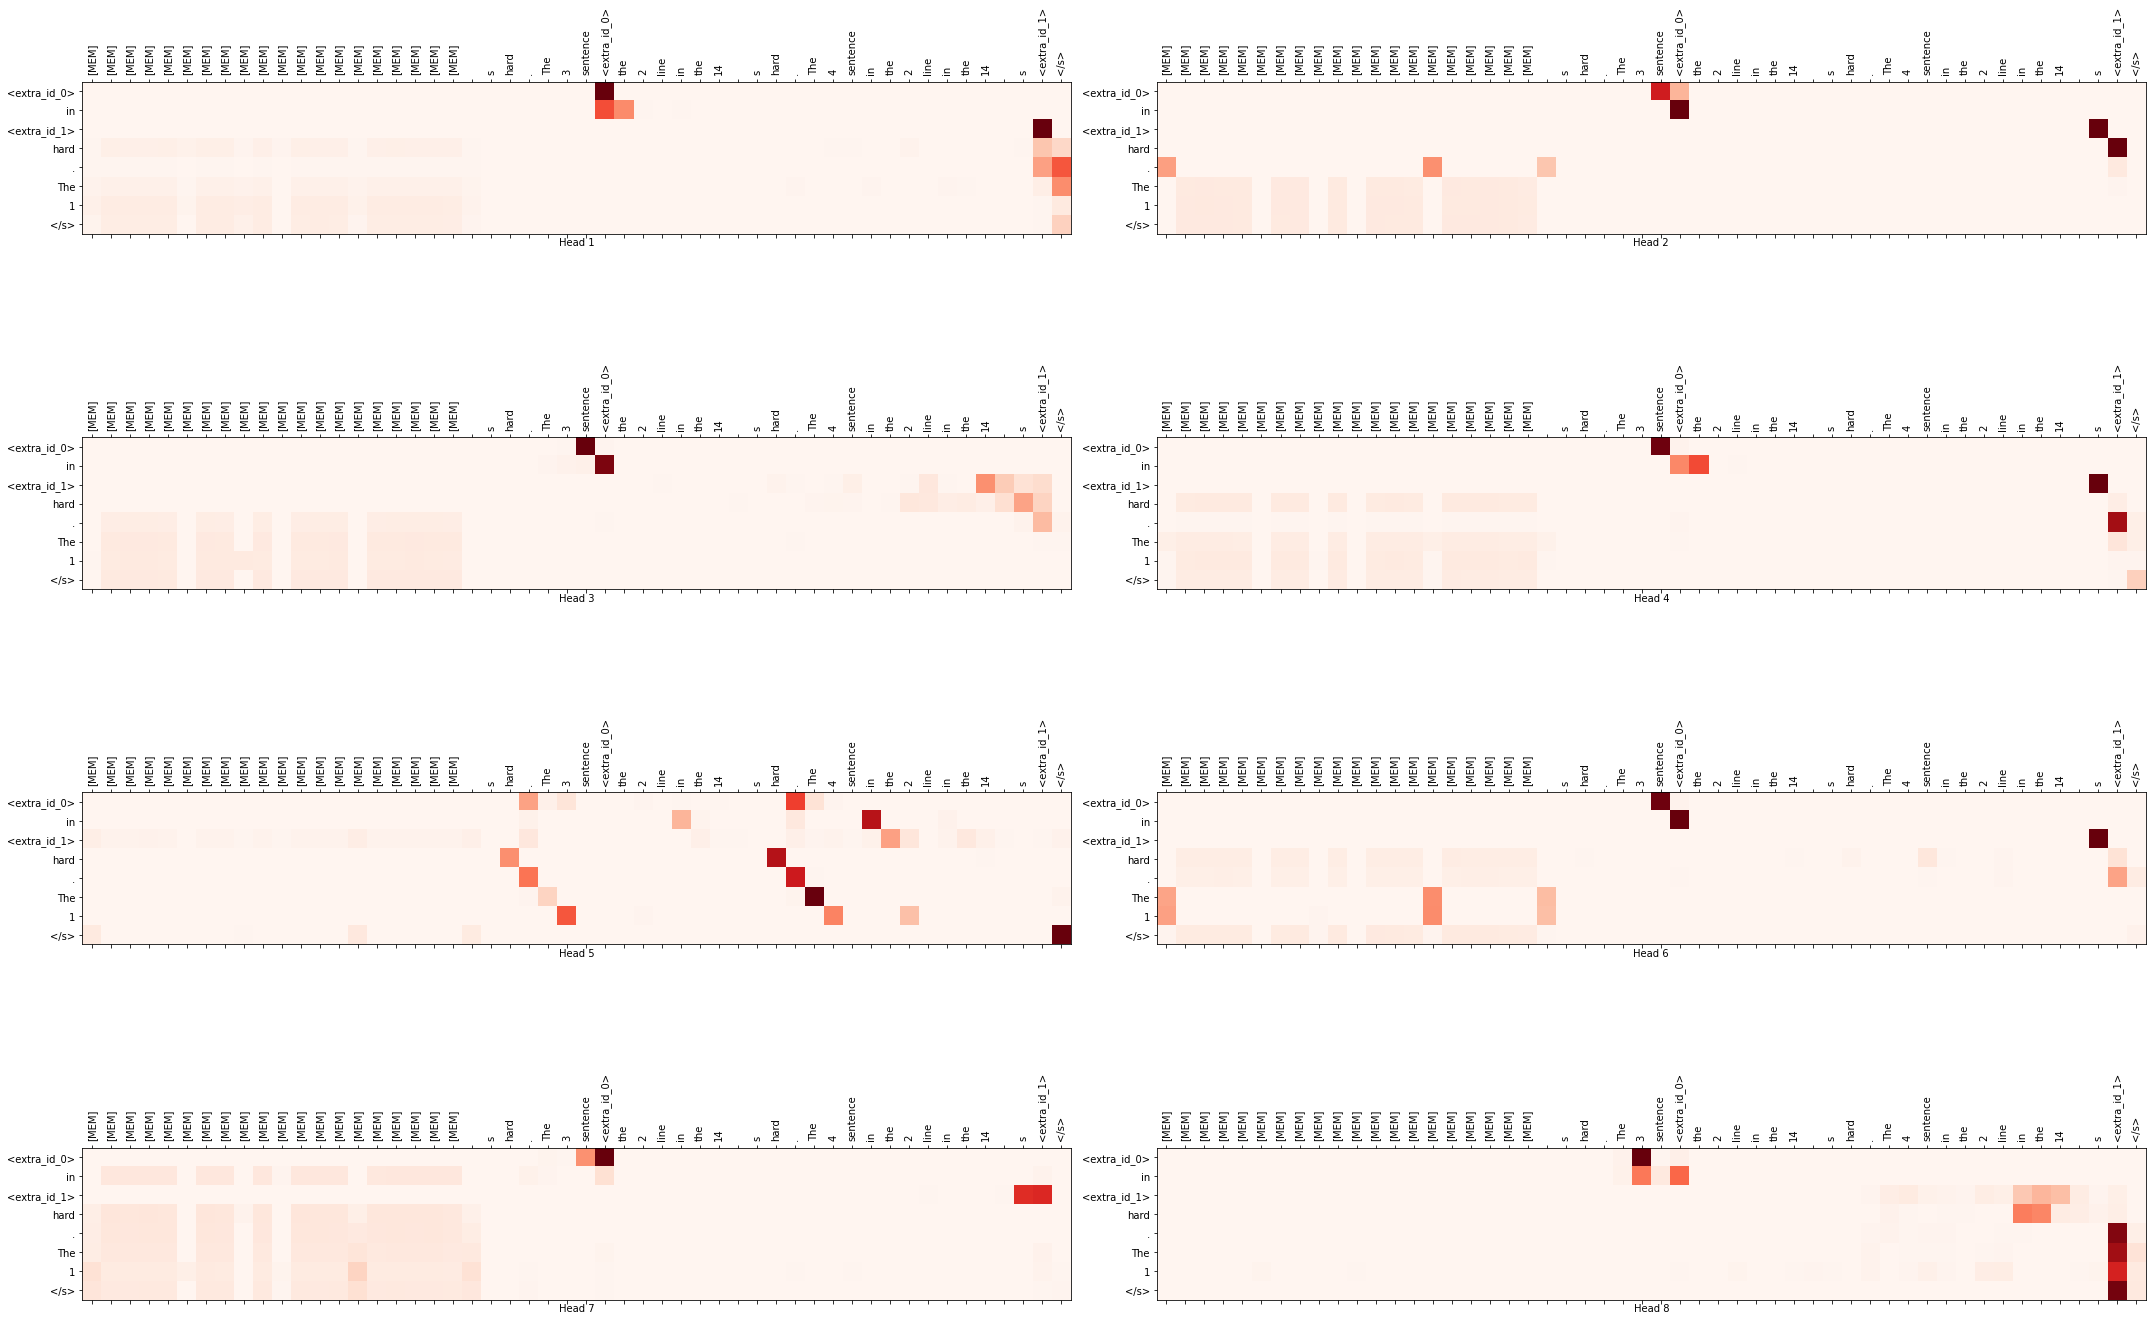

layer: 2
att_heads:


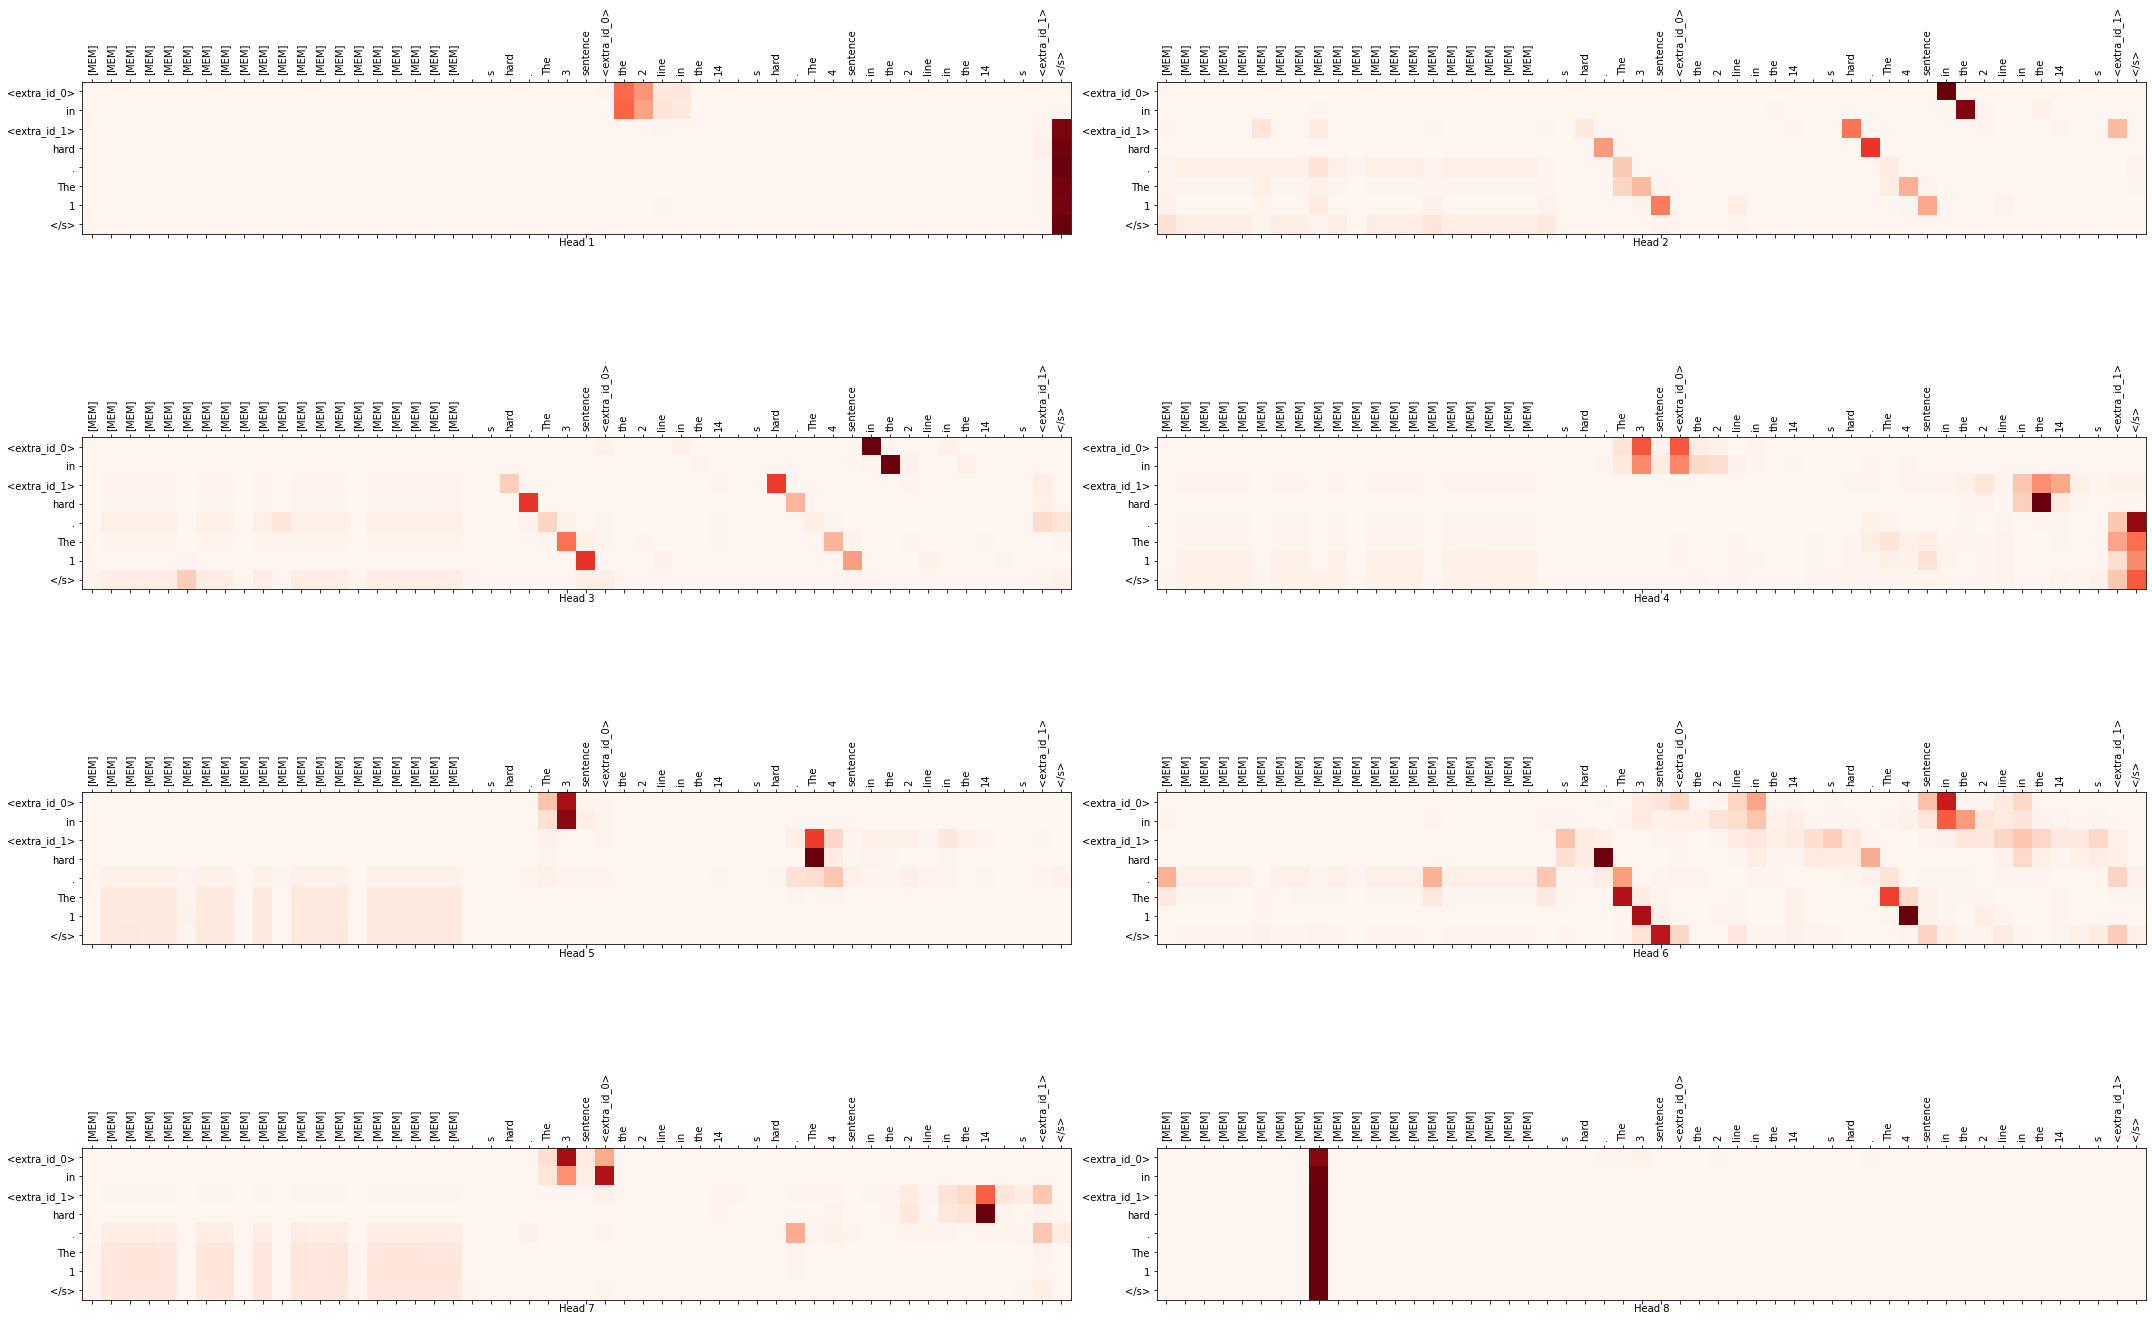

layer: 3
att_heads:


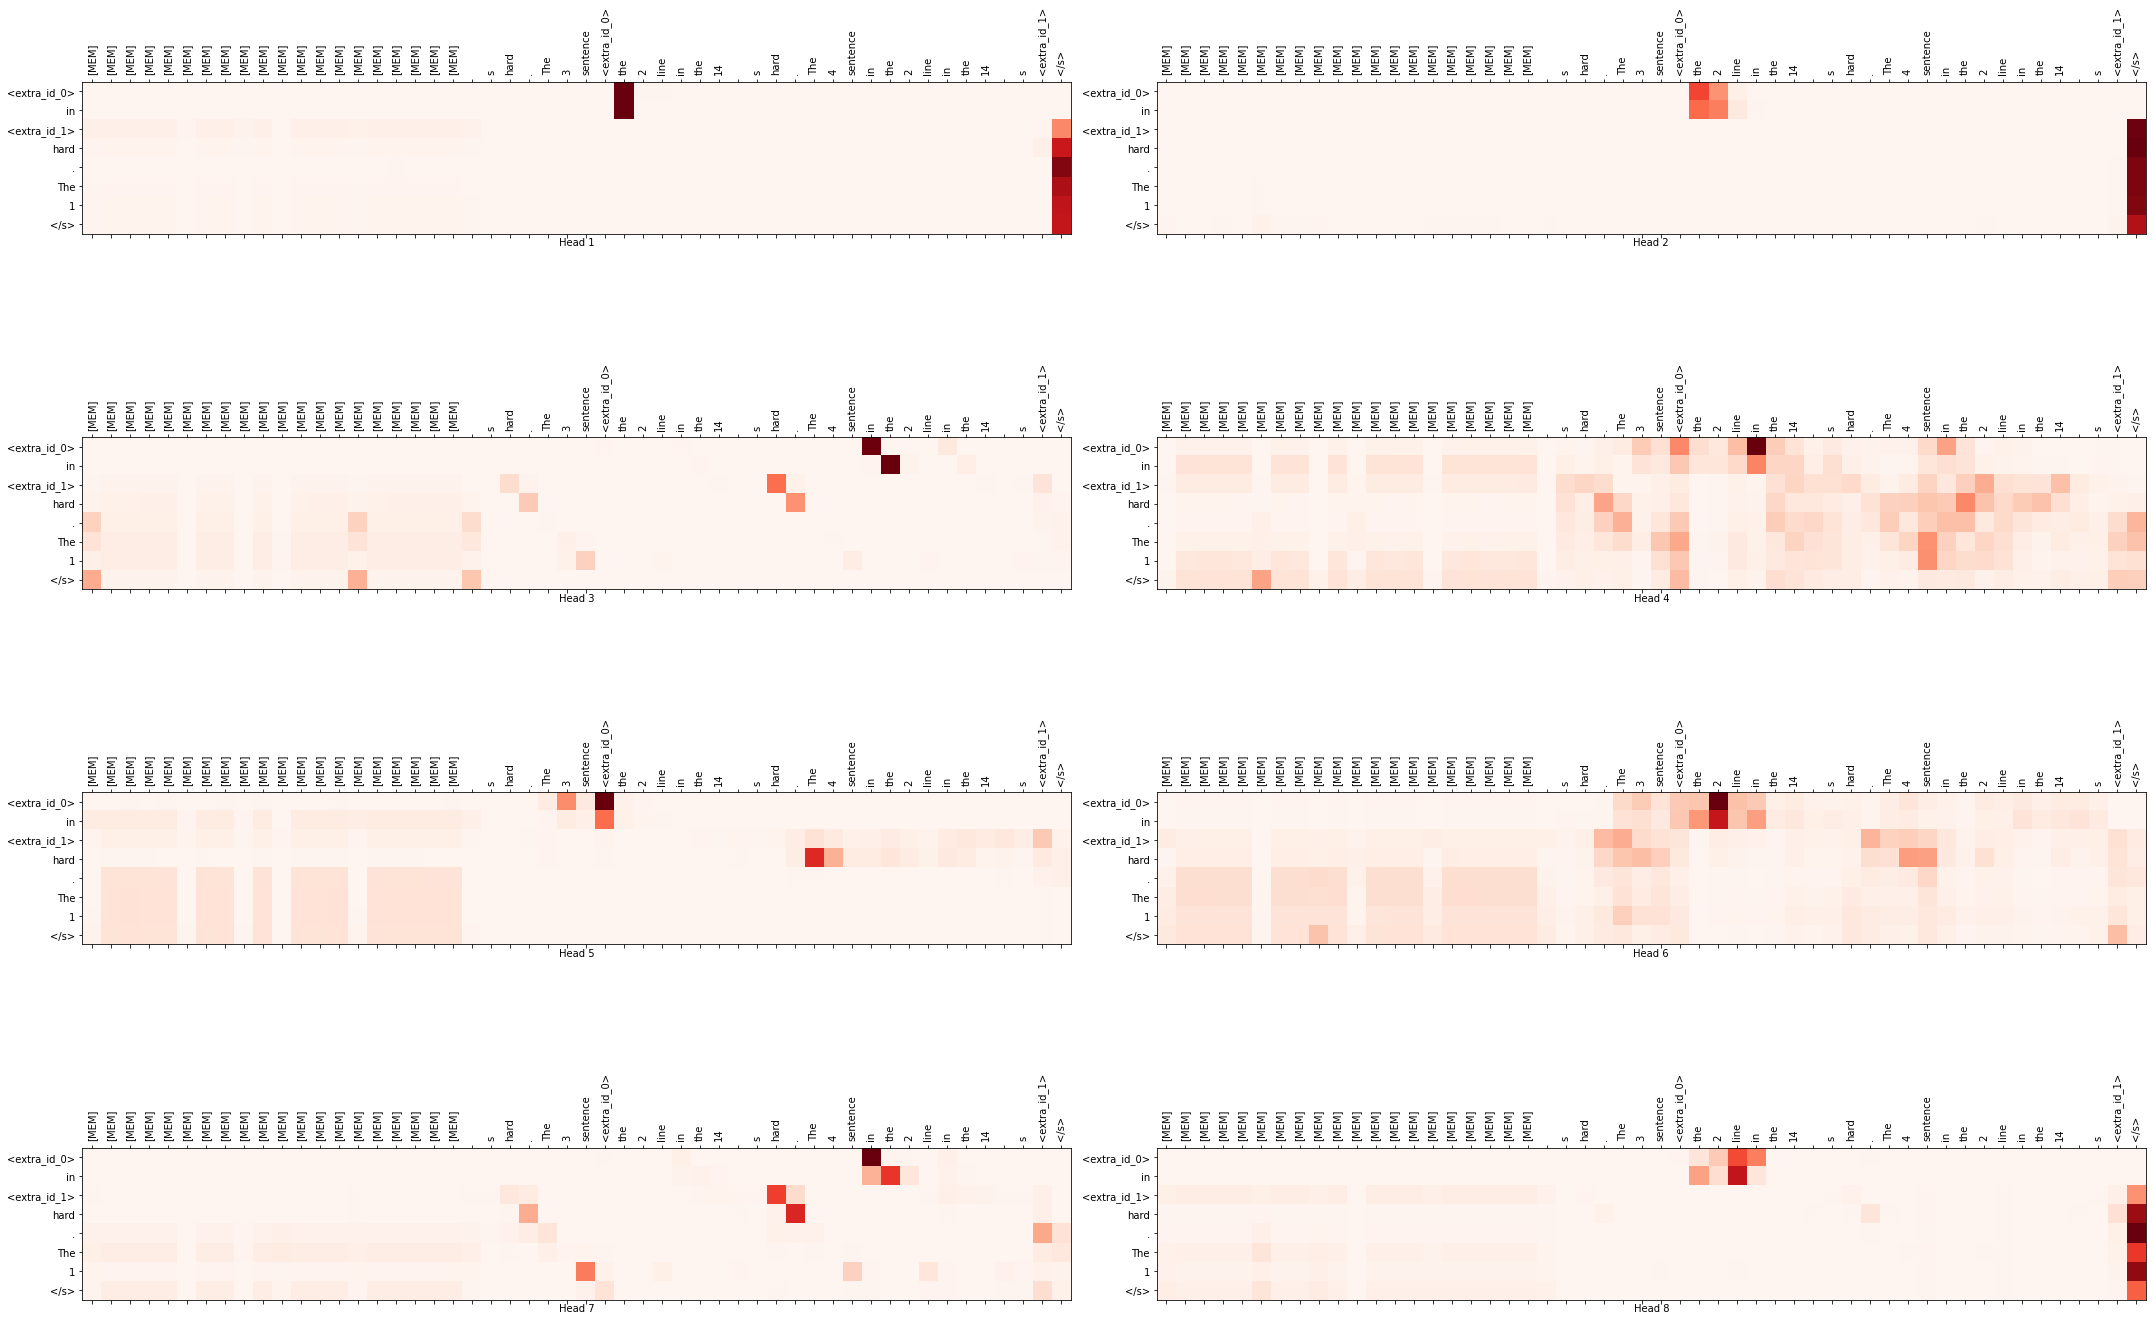

layer: 4
att_heads:


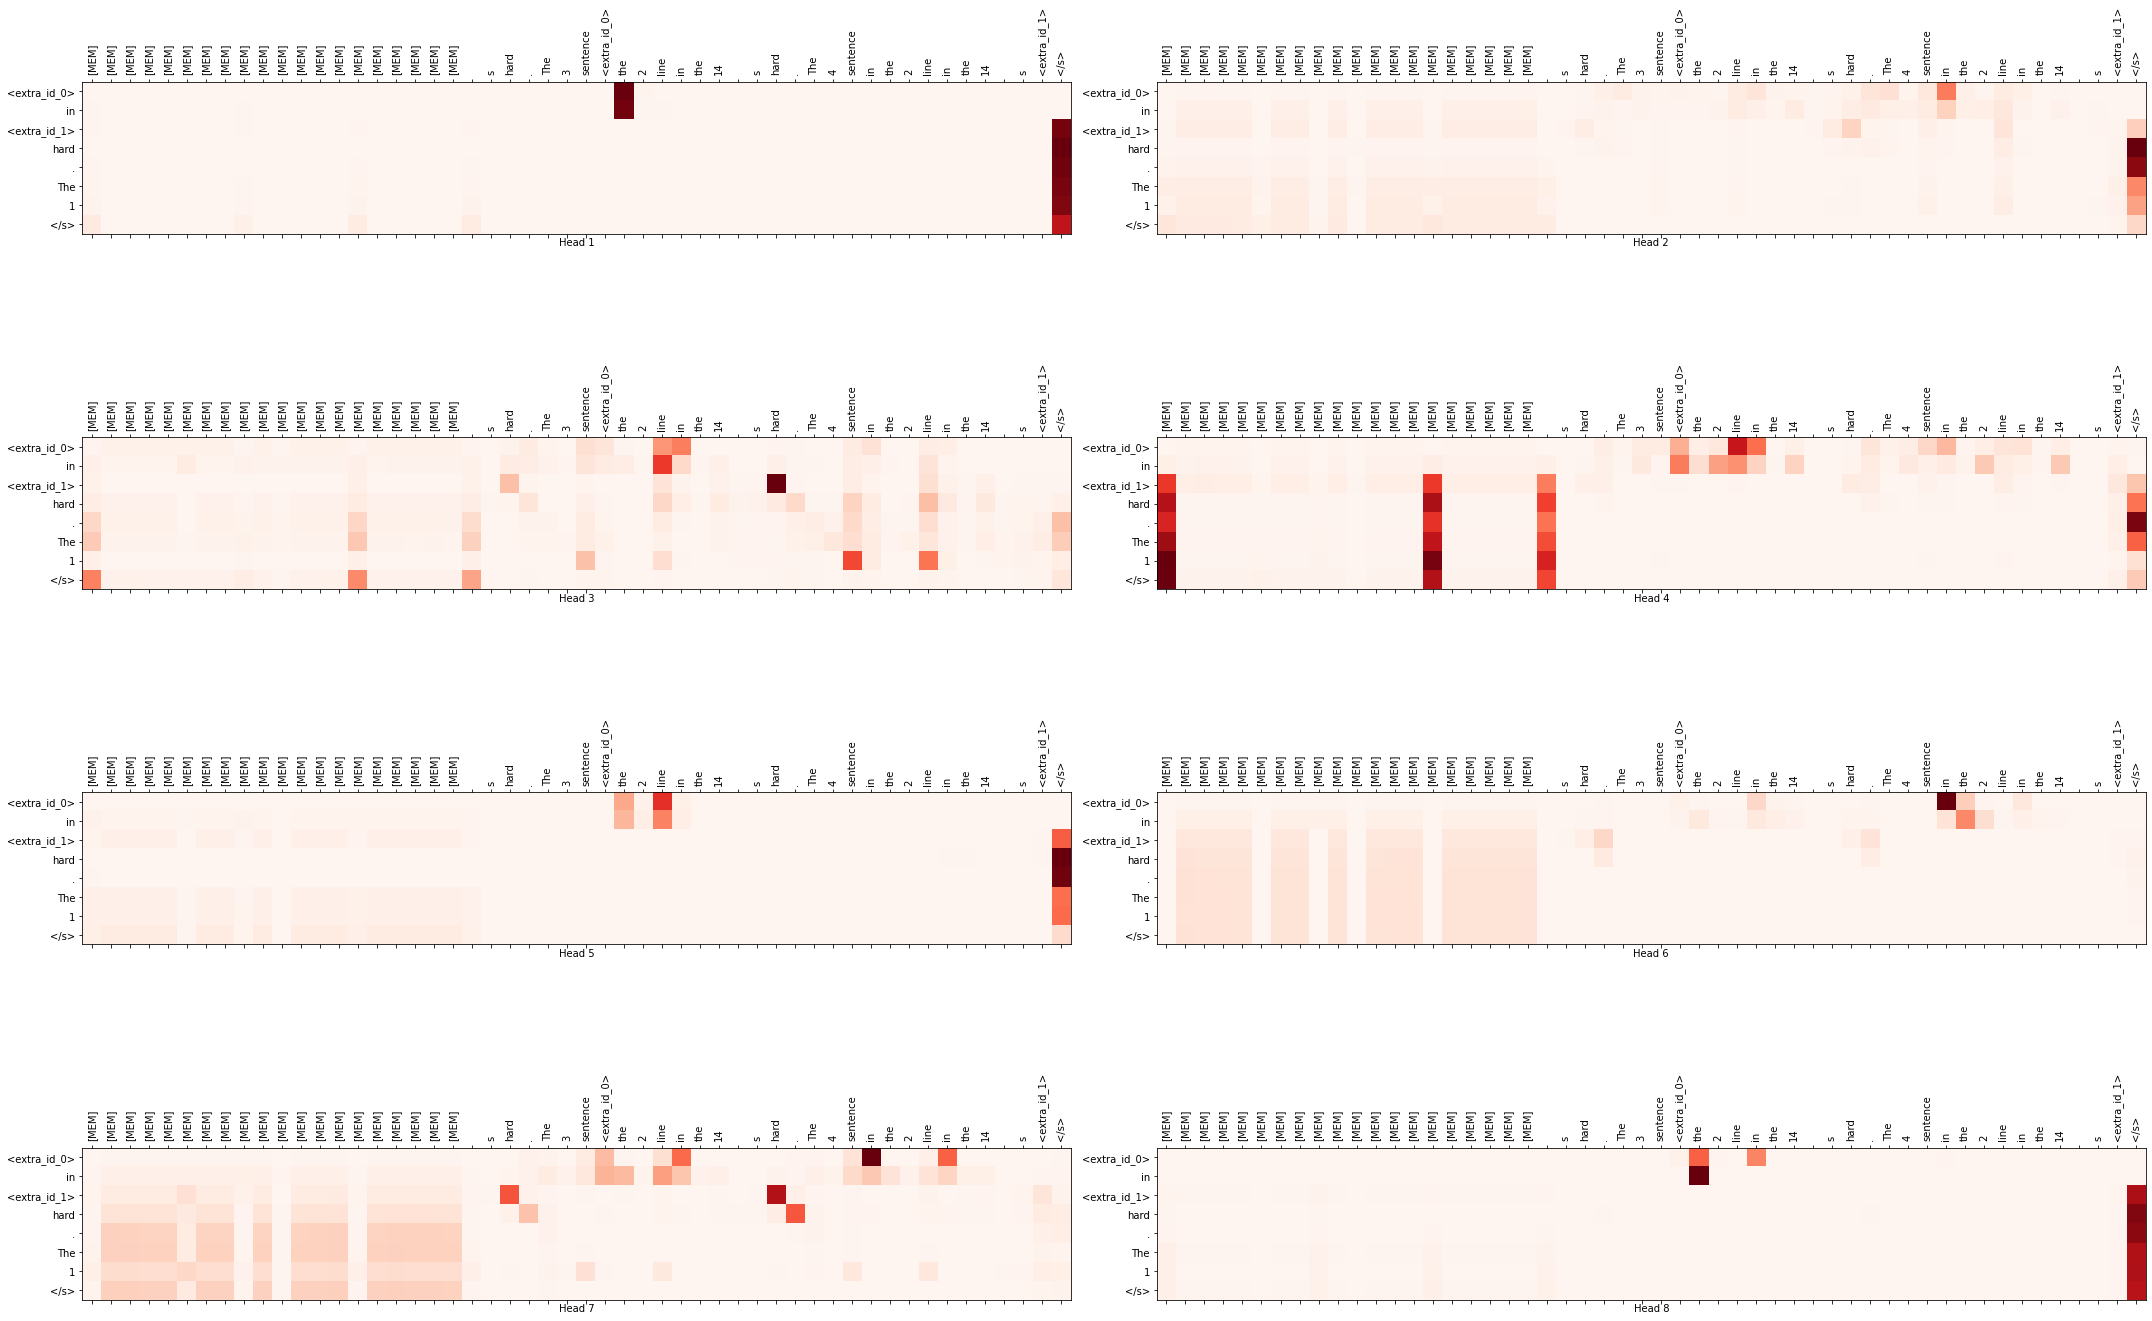

layer: 5
att_heads:


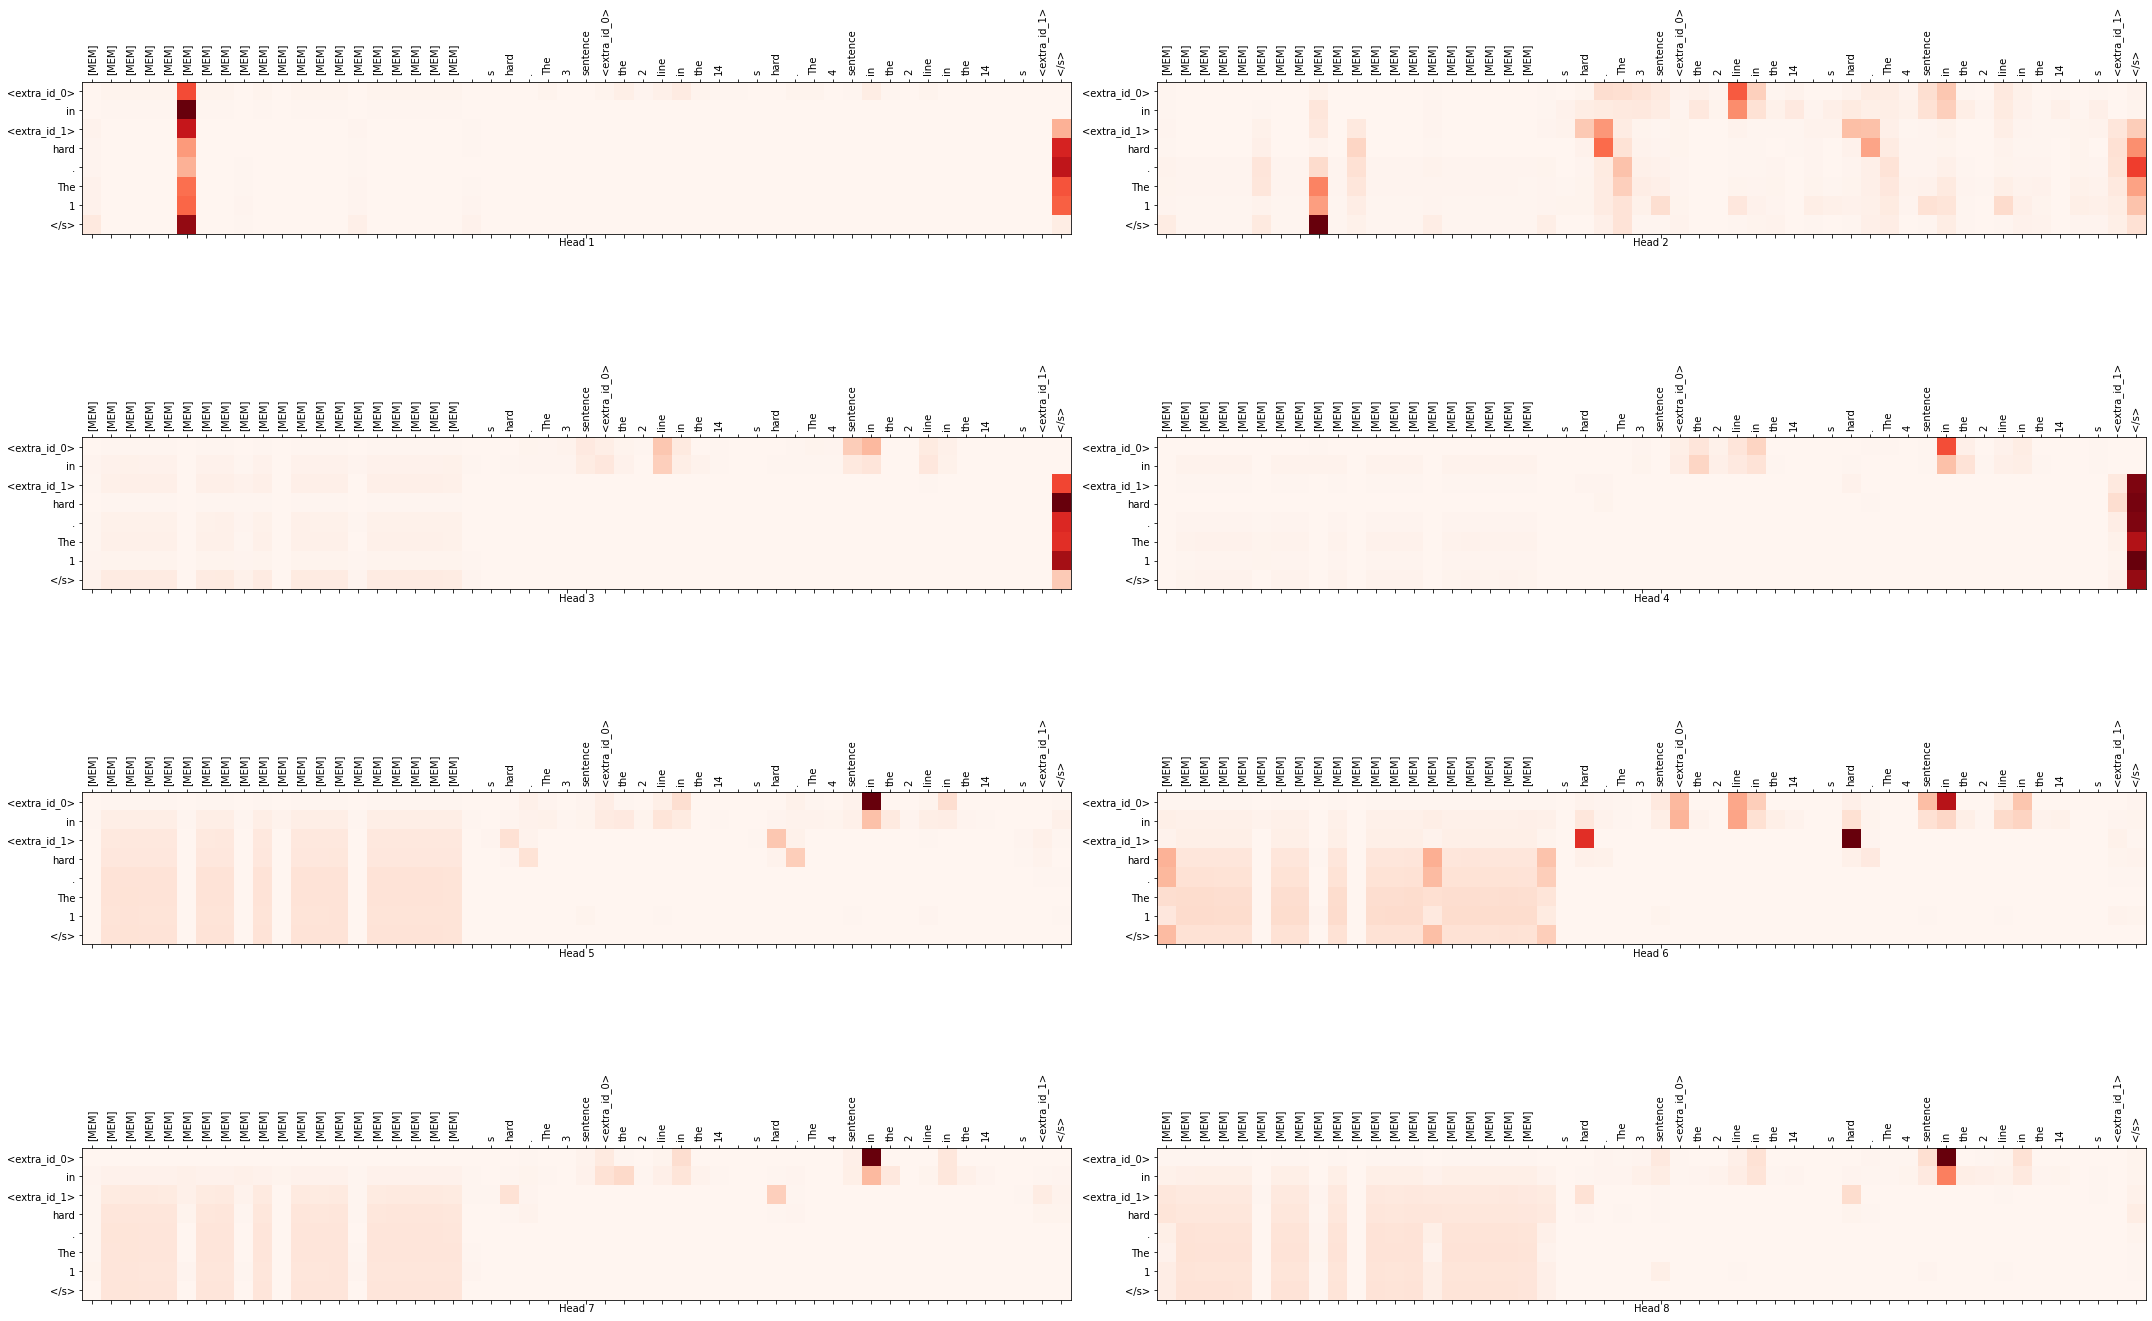

In [41]:
if num_memory_tokens > 0:
    print('cross-attention')
    for layer in range(len(outputs['cross_attentions'])):
        print(f'layer: {layer}')
        if isinstance(outputs['cross_attentions'][0], tuple):
            attentions = [layer_atts[0].detach().squeeze().numpy() if layer_atts[0] is not None else None for layer_atts in outputs['encoder_attentions']]
            cd_attentions = [layer_atts[1].detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
            p_attentions = [layer_atts[2].detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
        else:
            p_attentions = None
            attentions = [layer_atts.detach().squeeze().numpy() for layer_atts in outputs['cross_attentions']]
        if attentions[0] is not None:
            # has regular attention heads
            print(f'att_heads:')
            plot_attention_weights(attentions, tokens=tokens, layer=layer, y_tokens=y_tokens, p_attentions=None)
        if p_attentions:
            print(f'cdq att heads:')
            plot_attention_weights(cd_attentions, tokens=tokens, layer=layer, y_tokens=y_tokens, p_attentions=p_attentions)